In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("C:/Users/zhipe/OneDrive/Desktop/Master thesis/demostration")

from causal_ensemble_model import *
from utilities_ensemble import *
from utilities_plotting import *
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt
import time

$${B(t+1)} = 1.34{A(t-1)} - 1.23{A(t-3)} + {\epsilon}_{1}$$
$${C(t+1)} = -1.26{B(t)} + 1.03{B(t-1)} + {\epsilon}_{2}$$
$${E(t+1)} = 0.71{D(t-1)} + 1.05{D(t-2)} + {\epsilon}_{3}$$
A -> B, A -> C, D -> E

In [2]:
np.random.seed(0)
A = np.random.rand(20007) * 100
np.random.seed(10)
D = np.random.rand(20003) * 100
np.random.seed(3)
e_1 = np.random.normal(size=(20003,))
np.random.seed(5)
e_2 = np.random.normal(size=(20001,))
np.random.seed(8)
e_3 = np.random.normal(size=(20000,))
B = 1.34 * A[2:20005] - 1.23 * A[:20003] + e_1

C = -1.26 * B[1:20002] + 1.03 * B[:20001] + e_2
E = 0.71 * D[1:20001] + 1.05 * D[:20000] + e_3

A_0 = A[7:]
B_0 = B[3:]
C_0 = C[1:]
D_0 = D[3:]
E_0 = E

df = pd.DataFrame({'$X^1$': A_0, '$X^2$': B_0, '$X^3$': C_0, '$X^4$': D_0, '$X^5$': E_0})

In [3]:
data_use = df
feature_names = data_use.columns.tolist()

In [4]:
df

,$X^1$,$X^2$,$X^3$,$X^4$,$X^5$
0,89.177300,17.665687,6.480976,74.880388,82.553261
1,96.366276,6.249758,-37.619859,49.850701,48.259262
2,38.344152,39.697847,10.068871,22.479665,117.751170
3,79.172504,75.224841,-43.472427,19.806286,112.632056
4,52.889492,-58.933916,-52.312036,76.053071,66.007307
...,...,...,...,...,...
19995,92.330057,8.808167,-24.153748,98.919938,89.079843
19996,40.623497,-70.909364,19.952546,90.659799,131.591467
19997,94.428218,74.131983,98.745736,75.752336,169.802269
19998,72.272449,49.947460,-165.074562,89.655416,167.878448


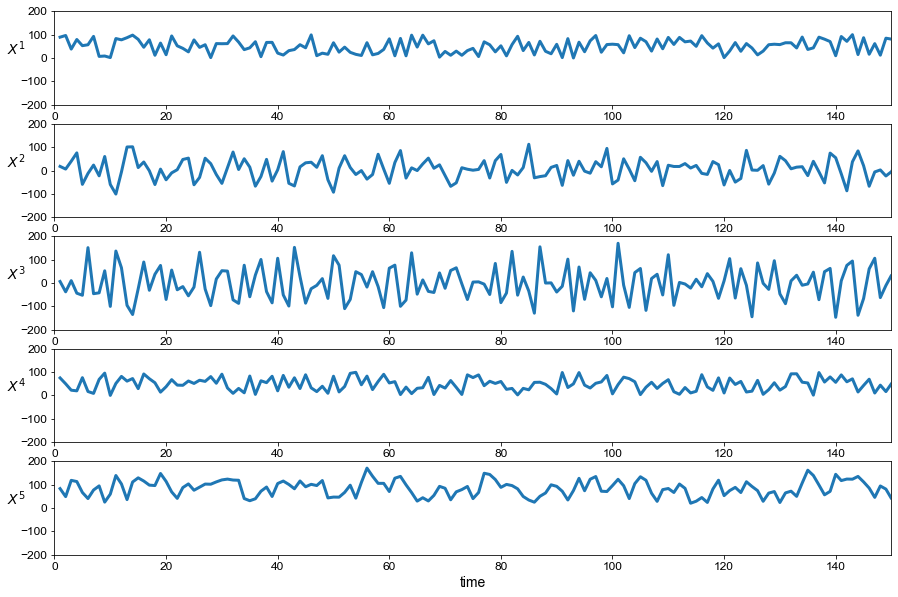

In [5]:
X = np.linspace(1,20000,20000).astype(int)
f_0, axes_0 = plt.subplots(5, 1, figsize=(15,10))

for i in range(5):
    k=i+1
    plt.subplot(5, 1, k)
    plt.plot(X, df[f'$X^{k}$'], linewidth=3)
    plt.xlabel('time', fontproperties = 'Arial', size=14)
    plt.ylabel(f'$X^{k}$', fontproperties = 'Arial', size=14, rotation=0)
    plt.yticks(fontproperties = 'Arial', size = 12)
    plt.xticks(fontproperties = 'Arial', size = 12)
    plt.xlim((0,150))
    plt.ylim((-200,200))

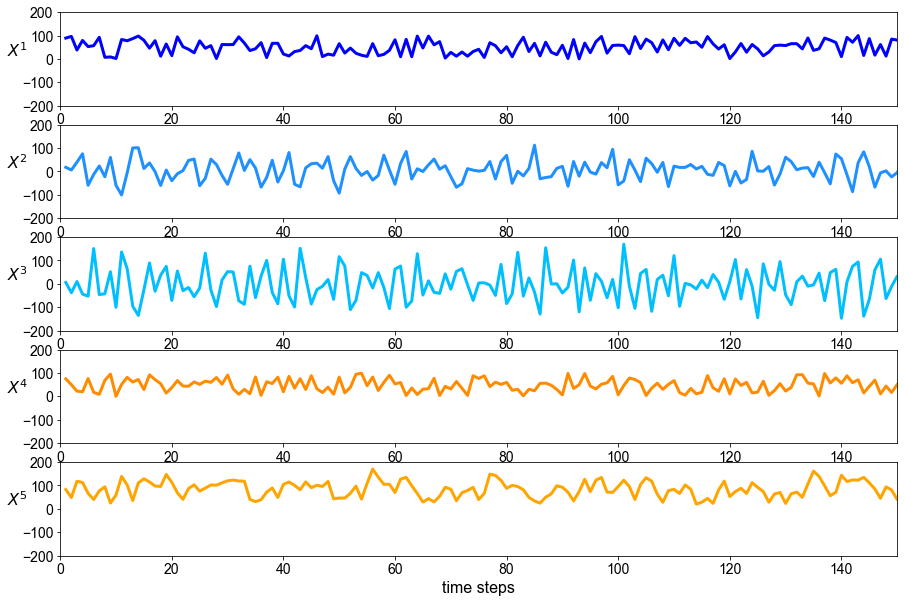

In [6]:
X = np.linspace(1,20000,20000).astype(int)
f_0, axes_0 = plt.subplots(5, 1, figsize=(15,10))

plt.subplot(5, 1, 1)
plt.plot(X, df['$X^1$'], linewidth=3, color='b')
plt.ylabel('$X^1$', fontproperties = 'Arial', size=16, rotation=0)
plt.yticks(fontproperties = 'Arial', size = 14)
plt.xticks(fontproperties = 'Arial', size = 14)
plt.xlim((0,150))
plt.ylim((-200,200))

plt.subplot(5, 1, 2)
plt.plot(X, df['$X^2$'], linewidth=3, color='dodgerblue')
plt.ylabel('$X^2$', fontproperties = 'Arial', size=16, rotation=0)
plt.yticks(fontproperties = 'Arial', size = 14)
plt.xticks(fontproperties = 'Arial', size = 14)
plt.xlim((0,150))
plt.ylim((-200,200))

plt.subplot(5, 1, 3)
plt.plot(X, df['$X^3$'], linewidth=3, color='deepskyblue')
plt.ylabel('$X^3$', fontproperties = 'Arial', size=16, rotation=0)
plt.yticks(fontproperties = 'Arial', size = 14)
plt.xticks(fontproperties = 'Arial', size = 14)
plt.xlim((0,150))
plt.ylim((-200,200))

plt.subplot(5, 1, 4)
plt.plot(X, df['$X^4$'], linewidth=3, color='darkorange')
plt.ylabel('$X^4$', fontproperties = 'Arial', size=16, rotation=0)
plt.yticks(fontproperties = 'Arial', size = 14)
plt.xticks(fontproperties = 'Arial', size = 14)
plt.xlim((0,150))
plt.ylim((-200,200))

plt.subplot(5, 1, 5)
plt.plot(X, df['$X^5$'], linewidth=3, color='orange')
plt.xlabel('time steps', fontproperties = 'Arial', size=16)
plt.ylabel('$X^5$', fontproperties = 'Arial', size=16, rotation=0)
plt.yticks(fontproperties = 'Arial', size = 14)
plt.xticks(fontproperties = 'Arial', size = 14)
plt.xlim((0,150))
plt.ylim((-200,200))

plt.savefig('C:/Users/zhipe/OneDrive/Desktop/Master thesis/codes/examples/results/4_01.jpg', 
            bbox_inches = 'tight',
            pad_inches=0.2,
            dpi=300)


In [7]:
df_process = df.copy()

for i in feature_names:
    q3, q1 = np.percentile(df_process[i], [90 ,10])
    iqr = q3 - q1
    upper = q3 + 2 * iqr
    lower = q1 - 2 * iqr
    df_process[i][df_process[i]>upper] = (upper + 0.01)
    df_process[i][df_process[i]<lower] = (lower - 0.01)

    n = len(df_process)
    j = 1
    while j < (n-1):
        if df_process[i][j] > upper or df_process[i][j] < lower:
            n_start = j-1
            n_end = j+1
            for k in range(n):
                if df_process[i][n_end] > upper or df_process[i][n_end] < lower:
                    n_end += 1
                    if n_end == n-1:
                        break
                else: 
                    break
            num = n_end - n_start - 1
            for l in range(num):
                df_process[i][j+l] = ((df_process[i][n_end] 
                                       - df_process[i][n_start]) 
                                      / (num+1) 
                                      * (l+1) 
                                      + df_process[i][n_start])
            j += num
        j += 1
                              
df_process          

,$X^1$,$X^2$,$X^3$,$X^4$,$X^5$
0,89.177300,17.665687,6.480976,74.880388,82.553261
1,96.366276,6.249758,-37.619859,49.850701,48.259262
2,38.344152,39.697847,10.068871,22.479665,117.751170
3,79.172504,75.224841,-43.472427,19.806286,112.632056
4,52.889492,-58.933916,-52.312036,76.053071,66.007307
...,...,...,...,...,...
19995,92.330057,8.808167,-24.153748,98.919938,89.079843
19996,40.623497,-70.909364,19.952546,90.659799,131.591467
19997,94.428218,74.131983,98.745736,75.752336,169.802269
19998,72.272449,49.947460,-165.074562,89.655416,167.878448


In [8]:
ce = causal_ensemble(df_process, feature_names, num_parts=12, threshold=0.3)

# 1. CCM 

In [9]:
causal_ccm_parts = ce.ccm(lag=1, 
                          embed=6, 
                          split_percent=0.75, 
                          num_iter=25, 
                          convergence_threshold=0.03)

In [10]:
causal_ccm_parts

array([[[0.    , 0.5857, 0.3794, 0.    , 0.    ],
        [0.    , 0.    , 0.8735, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.5552, 0.    ]],

       [[0.    , 0.5604, 0.3622, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.8698, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.5584, 0.    ]],

       [[0.    , 0.    , 0.3986, 0.    , 0.    ],
        [0.5798, 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.8834, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.5791, 0.    ]],

       [[0.    , 0.5887, 0.3909, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.8823, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.5657, 0. 

# 2. TE

In [12]:
start = time.time()

causal_nte_parts = ce.nte(k=6, max_lag=6)

end = time.time()
print(end-start)

307.9559907913208


In [13]:
causal_nte_parts

array([[[0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.6797, 0.3387, 0.    ],
        [0.323 , 0.    , 0.    , 0.3118, 0.    ],
        [0.4144, 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.6766, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , 0.3532, 0.    ],
        [0.    , 0.    , 0.6965, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.7044, 0.    , 0.    ],
        [0.3257, 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.3336, 0.    , 0.    , 0.    , 0. 

# 3. PCMCI

In [14]:
pc_alpha = [0.01, 0.02, 0.03, 0.04, 0.05]
causal_pcmciplus_parts = ce.pcmciplus(max_lag=6, 
                                      pc_alpha=pc_alpha, 
                                      cond_ind_test='parCorr')


##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05]
##

## pc_alpha = 0.01 (1/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable $X^1$

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link ($X^1$ -1) --> $X^1$ (1/30):

##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05]
##

## pc_alpha = 0.01 (1/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1
##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05]
##

## pc_alpha = 0.01 (1/5):




##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
## Variable $X^1$
##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02,

    Non-significance detected.
    Subset 0: () gives pval = 0.64802 / val = -0.009

    Link ($X^2$ -4) --> $X^1$ (10/30):    Subset 0: () gives pval = 0.00152 / val = -0.064    Non-significance detected.

    Subset 0: () gives pval = 0.55844 / val =  0.012

    Link ($X^2$ -2) --> $X^1$ (8/30):

    No conditions of dimension 0 left.
    Non-significance detected.

    Link ($X^2$ -5) --> $X^1$ (11/30):
    Non-significance detected.

    Link ($X^2$ -2) --> $X^1$ (8/30):    Subset 0: () gives pval = 0.11922 / val = -0.031    Subset 0: () gives pval = 0.97086 / val = -0.001

    Non-significance detected.

    Link ($X^2$ -5) --> $X^1$ (11/30):

    Subset 0: () gives pval = 0.86978 / val =  0.003
    Link ($X^2$ -4) --> $X^1$ (10/30):
    Non-significance detected.

    Link ($X^2$ -3) --> $X^1$ (9/30):

    Non-significance detected.    Subset 0: () gives pval = 0.73698 / val =  0.007

    Non-significance detected.

    Link ($X^2$ -3) --> $X^1$ (9/30):
    Subset 0: () gives pva




    Link ($X^4$ -2) --> $X^1$ (20/30):

    Link ($X^4$ -1) --> $X^1$ (19/30):

    Link ($X^4$ -1) --> $X^1$ (19/30):

    Link ($X^4$ -2) --> $X^1$ (20/30):
    Subset 0: () gives pval = 0.83753 / val = -0.004    Subset 0: () gives pval = 0.00349 / val = -0.059    Subset 0: () gives pval = 0.46260 / val =  0.015
    No conditions of dimension 0 left.


    Link ($X^4$ -2) --> $X^1$ (20/30):
    Subset 0: () gives pval = 0.84078 / val = -0.004    Subset 0: () gives pval = 0.80524 / val = -0.005
    Non-significance detected.

    Non-significance detected.
    Link ($X^4$ -3) --> $X^1$ (21/30):

    Non-significance detected.    Subset 0: () gives pval = 0.43988 / val = -0.015
    Non-significance detected.

    Link ($X^4$ -4) --> $X^1$ (22/30):

    Subset 0: () gives pval = 0.96768 / val =  0.001    Subset 0: () gives pval = 0.49613 / val = -0.014
    Non-significance detected.
    Non-significance detected.


    Link ($X^4$ -2) --> $X^1$ (20/30):

    Non-significance detected

        ($X^2$ -1): max_pval = 0.00152, min_val =  0.064
    Subset 0: () gives pval = 0.94715 / val = -0.001
    Non-significance detected.
        ($X^1$ -5): max_pval = 0.00661, min_val =  0.054

Testing condition sets of dimension 1:

    Link ($X^2$ -1) --> $X^1$ (1/2):

    Link ($X^1$ -2) --> $X^2$ (2/30):

# pc_alpha = 0.01 (1/1):
    Subset 0: () gives pval = 0.71118 / val =  0.007


Testing condition sets of dimension 0:

    Link ($X^1$ -1) --> $X^2$ (1/30):
    Subset 0: () gives pval = 0.96870 / val =  0.001
    Non-significance detected.

    Variable $X^1$ has 0 link(s):
    Link ($X^1$ -4) --> $X^2$ (4/30):
    Link ($X^1$ -4) --> $X^2$ (4/30):

Algorithm converged for variable $X^1$

## Variable $X^2$

Iterating through pc_alpha = [0.01]:
    Subset 0: () gives pval = 0.31703 / val = -0.020    Subset 0: () gives pval = 0.59747 / val =  0.011
    Non-significance detected.

    Subset 0: () gives pval = 0.72814 / val =  0.007
    Non-significance detected.

    Non-sign

    Subset 0: () gives pval = 0.30445 / val = -0.021    Non-significance detected.    Subset 0: () gives pval = 0.81092 / val = -0.005
    Non-significance detected.

    Link ($X^2$ -5) --> $X^2$ (11/30):
    Subset 0: () gives pval = 0.60285 / val = -0.010
    Subset 0: () gives pval = 0.69102 / val = -0.008    Non-significance detected.



    Link ($X^1$ -6) --> $X^2$ (6/30):


    Link ($X^2$ -5) --> $X^2$ (11/30):
    Non-significance detected.

    Link ($X^2$ -6) --> $X^2$ (12/30):
    Non-significance detected.    Subset 0: () gives pval = 0.98539 / val =  0.000
    Non-significance detected.

    Link ($X^2$ -1) --> $X^2$ (7/30):
    Subset 0: () gives pval = 0.00000 / val = -0.490    Subset 0: () gives pval = 0.00000 / val = -0.505    Subset 0: () gives pval = 0.00000 / val = -0.516
    No conditions of dimension 0 left.


    No conditions of dimension 0 left.

    Link ($X^2$ -3) --> $X^2$ (9/30):
    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.23581 

    Subset 0: () gives pval = 0.00656 / val = -0.054
    Subset 0: () gives pval = 0.19717 / val =  0.026
    Link ($X^3$ -4) --> $X^2$ (16/30):

    Non-significance detected.

    Subset 0: () gives pval = 0.04116 / val =  0.041    No conditions of dimension 0 left.

    Link ($X^3$ -5) --> $X^2$ (17/30):
    Subset 0: () gives pval = 0.26681 / val = -0.022    Non-significance detected.

    Link ($X^3$ -6) --> $X^2$ (18/30):


    Link ($X^4$ -6) --> $X^2$ (24/30):
    Non-significance detected.

    Link ($X^3$ -4) --> $X^2$ (16/30):
    Subset 0: () gives pval = 0.10160 / val =  0.033
    Subset 0: () gives pval = 0.52392 / val =  0.013    Subset 0: () gives pval = 0.21206 / val = -0.025
    Non-significance detected.

    Link ($X^4$ -1) --> $X^2$ (19/30):
    Non-significance detected.
    Non-significance detected.

    Link ($X^4$ -4) --> $X^2$ (22/30):

    Non-significance detected.

    Link ($X^4$ -3) --> $X^2$ (21/30):
    Subset 0: () gives pval = 0.24811 / val =  0.023


    Subset 0: () gives pval = 0.76813 / val = -0.006
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.392

    Link ($X^1$ -2) --> $X^2$ (1/4):    Subset 0: () gives pval = 0.45001 / val =  0.015
    Subset 0: () gives pval = 0.86240 / val =  0.003    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -1.000
    Subset 0: ($X^1$ -4)  gives pval = 0.00000 / val =  1.000
    Non-significance detected.

    No conditions of dimension 1 left.

    Link ($X^1$ -4) --> $X^2$ (2/4):


    Link ($X^5$ -3) --> $X^2$ (27/30):
    Non-significance detected.

    Link ($X^5$ -2) --> $X^2$ (26/30):

    No conditions of dimension 1 left.

    Link ($X^2$ -2) --> $X^2$ (3/4):
    Non-significance detected.
Testing condition sets of dimension 1:

    Link ($X^1$ -2) --> $X^2$ (1/4):

    Subset 0: () gives pval = 0.17081 / val = -0.027
    Non-significance detected.

    Link ($X^5$ -4) --> $X^2$ (28/30):

    Link ($X^5$ -5) --> $X^2$ (29/30):
    Subset 0: () gives pval = 0.39212 / val =  0.017

    Subset 0: ($X^1$ -4) ($X^2$ -2)  gives pval = 0.00000 / val =  1.000    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val =  0.587

    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 4 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.735
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.674
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.490
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.402

Testing condition sets of dimension 2:

    Link ($X^1$ -2) --> $X^2$ (1/4):
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^1$ -4) --> $X^2$ (2/4):
    No conditions of dimension 1 left.    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -0.737    Subset 0: () gives pval = 0.01965 / val =  0.047
    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^2$ (4/4):


    Non-significance detected.



    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 4 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.733
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.671
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.480
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.380

Testing condition sets of dimension 2:

    Link ($X^1$ -2) --> $X^2$ (1/4):


Algorithm converged for variable $X^2$
    Subset 0: () gives pval = 0.32690 / val = -0.020
## Variable $X^3$
    Non-significance detected.

    Link ($X^1$ -2) --> $X^3$ (2/30):


Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link ($X^1$ -1) --> $X^3$ (1/30):
    Subset 0: ($X^1$ -2) ($X^2$ -2)  gives pval = 0.00000 / val = -0.999
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^2$ -2) --> $X^2$ (3/4):
    Subset 0: ($X^1$ -2) ($X^1$ -4)  

    Subset 0: () gives pval = 0.00000 / val = -0.407    Subset 0: () gives pval = 0.00000 / val = -0.769    Subset 0: () gives pval = 0.00000 / val =  0.459
    No conditions of dimension 0 left.

    Link ($X^1$ -5) --> $X^3$ (5/30):

    No conditions of dimension 0 left.

    Link ($X^2$ -2) --> $X^3$ (8/30):

    No conditions of dimension 0 left.

    Link ($X^2$ -1) --> $X^3$ (7/30):
    Subset 0: () gives pval = 0.00000 / val =  0.536
    No conditions of dimension 0 left.

    Link ($X^1$ -6) --> $X^3$ (6/30):
    Subset 0: () gives pval = 0.52241 / val = -0.013
    Non-significance detected.

    Link ($X^1$ -2) --> $X^3$ (2/30):
    Subset 0: ($X^1$ -4) ($X^2$ -2)  gives pval = 0.00000 / val =  1.000    Subset 0: () gives pval = 0.00000 / val = -0.782

    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.00000 / val =  0.530    Still subsets of dimension 2 left, but q_max = 1 reached.



    Link ($X^2$ -2) --> $X^3$ (8/30):
    Link ($X^1$ -4) --> $X^2$ (2/6


    Link ($X^2$ -5) --> $X^3$ (11/30):
    Subset 0: () gives pval = 0.56492 / val =  0.012
    Non-significance detected.

    Link ($X^2$ -6) --> $X^3$ (12/30):
    Subset 0: () gives pval = 0.00000 / val = -0.772
    Subset 0: () gives pval = 0.71111 / val =  0.007    No conditions of dimension 0 left.
    Non-significance detected.

    Link ($X^2$ -2) --> $X^3$ (8/30):


    Link ($X^3$ -1) --> $X^3$ (13/30):
    Subset 0: ($X^1$ -2) ($X^1$ -4)  gives pval = 0.12135 / val =  0.031
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.720
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.656

Algorithm converged for variable $X^2$

## Variable $X^3$

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link ($X^1$ -1) --> $X^3$ (1/30):
   

    Subset 0: () gives pval = 0.25829 / val = -0.023
    Non-significance detected.    Subset 0: () gives pval = 0.05432 / val = -0.039    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val =  0.510

    Link ($X^3$ -6) --> $X^3$ (18/30):


    No conditions of dimension 0 left.

    Link ($X^1$ -6) --> $X^3$ (6/30):
    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val =  0.362


    Subset 0: () gives pval = 0.00000 / val =  0.244    No conditions of dimension 0 left.

    Link ($X^2$ -4) --> $X^3$ (10/30):

    No conditions of dimension 0 left.

    Link ($X^3$ -4) --> $X^3$ (16/30):
    Link ($X^3$ -1) --> $X^3$ (13/30):

    Subset 0: () gives pval = 0.27906 / val =  0.022
    Link ($X^3$ -5) --> $X^3$ (17/30):    Subset 0: () gives pval = 0.00000 / val = -0.241
    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val = -0.408    Subset 0: () gives pval = 0.80447 / val = -0.005

    Link ($X^4$ -1) --> $X^3$ (19/30):

    No

    Subset 0: () gives pval = 0.02733 / val =  0.044    Subset 0: () gives pval = 0.00000 / val =  0.260
    Non-significance detected.

    Link ($X^2$ -6) --> $X^3$ (12/30):
    Subset 0: () gives pval = 0.22654 / val = -0.024
    Subset 0: () gives pval = 0.55991 / val =  0.012
    Non-significance detected.    No conditions of dimension 0 left.

    Link ($X^4$ -5) --> $X^3$ (23/30):
    Subset 0: () gives pval = 0.91035 / val =  0.002
    Non-significance detected.

    Link ($X^5$ -4) --> $X^3$ (28/30):


    Link ($X^3$ -4) --> $X^3$ (16/30):

    Non-significance detected.

    Link ($X^4$ -4) --> $X^3$ (22/30):
    Subset 0: () gives pval = 0.23011 / val =  0.024    Subset 0: () gives pval = 0.00000 / val = -0.419
    Subset 0: () gives pval = 0.16978 / val =  0.028    Subset 0: () gives pval = 0.50250 / val = -0.013    No conditions of dimension 0 left.
    Non-significance detected.

    Link ($X^5$ -1) --> $X^3$ (25/30):
    Subset 0: () gives pval = 0.05656 / val = -0.038


    Subset 0: () gives pval = 0.13836 / val = -0.030    Subset 0: ($X^2$ -2)  gives pval = 0.00000 / val = -1.000    Subset 0: () gives pval = 0.10118 / val = -0.033
    Subset 0: () gives pval = 0.25254 / val = -0.023    Subset 0: () gives pval = 0.42086 / val =  0.016    Non-significance detected.
    Non-significance detected.

    Link ($X^4$ -6) --> $X^3$ (24/30):

    Link ($X^2$ -2) --> $X^3$ (2/11):



    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  1.000    No conditions of dimension 1 left.
    Non-significance detected.    Non-significance detected.
    No conditions of dimension 1 left.

    Link ($X^1$ -3) --> $X^3$ (3/11):
    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 


Updating parents:

    Variable $X^3$ has 11 link(s):
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.770
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.627
        ($X^1$ -3): max_pval = 0.00000, min_val =  0.552
        ($X^1$ -5

    Subset 0: () gives pval = 0.77604 / val =  0.006    No conditions of dimension 1 left.
    Non-significance detected.

    Link ($X^2$ -2) --> $X^3$ (2/11):


    Link ($X^5$ -1) --> $X^3$ (25/30):
    Subset 0: ($X^2$ -1)  gives pval = 0.46745 / val =  0.015    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  1.000
    No conditions of dimension 1 left.

    Link ($X^1$ -3) --> $X^3$ (3/11):

    Subset 0: ($X^2$ -1)  gives pval = 0.83104 / val =  0.004    Non-significance detected.    Subset 0: () gives pval = 0.04008 / val =  0.041
    Non-significance detected.

    Link ($X^1$ -5) --> $X^3$ (4/11):

    Non-significance detected.

    Link ($X^4$ -2) --> $X^3$ (20/30):
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.343


    Link ($X^3$ -2) --> $X^3$ (5/11):
    No conditions of dimension 1 left.
    Subset 0: () gives pval = 0.89058 / val =  0.003
    Non-significance detected.

    Link ($X^5$ -6) --> $X^3$ (30/30):

    Link ($X^1$ -4) --> $X^3$ (6/11):    Sub

    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.805
    No conditions of dimension 1 left.    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.725

    Link ($X^3$ -3) --> $X^3$ (11/11):

    No conditions of dimension 1 left.

    Link ($X^1$ -6) --> $X^3$ (7/11):
    Subset 0: ($X^2$ -1)  gives pval = 0.22541 / val =  0.024
    Non-significance detected.

    Link ($X^2$ -4) --> $X^3$ (9/11):
    Subset 0: ($X^2$ -1)  gives pval = 0.52363 / val = -0.013
    Non-significance detected.

    Link ($X^2$ -4) --> $X^3$ (9/11):
    Subset 0: () gives pval = 0.74362 / val =  0.007
    Non-significance detected.

    Link ($X^5$ -6) --> $X^3$ (30/30):
    Subset 0: ($X^2$ -2) ($X^1$ -4)  gives pval = 0.00000 / val = -1.000
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.503    Still subsets of dimension 2 left, but q_max = 1 reached.
    Subset 0: () gives pval = 0.40127 / val =  0.017
    No conditions of dimension 1 left.

    Link ($X^3$ -3) --> $X^3$ (10/11):
   

    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.491    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.733    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  1.000

    No conditions of dimension 1 left.

    Link ($X^1$ -6) --> $X^3$ (7/11):
    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^3$ (10/11):

    No conditions of dimension 1 left.

    Link ($X^1$ -3) --> $X^3$ (3/12):
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.375    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.396
    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^3$ (11/11):
    Subset 0: () gives pval = 0.13531 / val = -0.030

    Non-significance detected.

    Link ($X^5$ -6) --> $X^3$ (30/30):
    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^3$ (11/11):
    Subset 0: ($X^2$ -1)  gives pval = 0.41576 / val =  0.016    Subset 0: ($X^2$ -1) ($X^1$ -4)  gives pval = 0.00000 / val =  1.000    Subset 0: ($X^2$ -1) ($X^2$ -2)  giv

    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.719    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.52846 / val = -0.013
    Non-significance detected.

    Link ($X^3$ -2) --> $X^3$ (6/8):
    No conditions of dimension 1 left.

    Link ($X^1$ -6) --> $X^3$ (7/12):

    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.816
    No conditions of dimension 1 left.

    Link ($X^3$ -3) --> $X^3$ (11/11):
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.42857 / val = -0.016    Subset 0: ($X^2$ -1) ($X^1$ -4)  gives pval = 0.00000 / val =  1.000
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^1$ -4) --> $X^3$ (3/8):

    Subset 0: ($X^2$ -2) ($X^1$ -4)  gives pval = 0.00000 / val = -1.000    Non-significance detected.
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^2$ -2) --> $X^3$ (2/8):


    Link ($X^3$ -2) --> $X^3$ (5/8):
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.57822 / val = -0.011
    Non-signific

    Subset 0: () gives pval = 0.28229 / val =  0.022    Subset 0: ($X^2$ -1)  gives pval = 0.94249 / val =  0.001
    Non-significance detected.
    Subset 0: () gives pval = 0.97635 / val = -0.001
    Non-significance detected.

    Link ($X^2$ -4) --> $X^3$ (9/14):

    Non-significance detected.

    Link ($X^1$ -5) --> $X^4$ (5/30):

    Link ($X^1$ -2) --> $X^4$ (2/30):
    Subset 0: () gives pval = 0.91300 / val = -0.002    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.51544 / val = -0.013

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:
    Non-significance detected.

    Link ($X^1$ -6) --> $X^4$ (6/30):

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.776
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.636

Algorithm converged for variable $X^3$

## Variable $X^4$

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):


    Subset 0: () gives pval = 0.97780 / val =  0.001    Subset 0: ($X^2$ -1) ($X^1$ -4)  gives pval = 0.00000 / val =  1.000
    Still subsets of dimension 2 left, but q_max = 1 reached.
    Non-significance detected.

    Link ($X^2$ -1) --> $X^4$ (7/30):
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.43499 / val = -0.016

    Non-significance detected.

    Link ($X^3$ -1) --> $X^3$ (7/8):
    Subset 0: () gives pval = 0.37696 / val =  0.018    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.06361 / val = -0.037
    Link ($X^1$ -4) --> $X^3$ (3/8):
    Non-significance detected.

    Link ($X^1$ -4) --> $X^4$ (4/30):


    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.772
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.628

Algorithm converged for variable $X^3$

## Variable $X^4$

Ite


    Link ($X^3$ -2) --> $X^4$ (14/30):
    Subset 0: () gives pval = 0.70497 / val =  0.008
    Non-significance detected.

    Link ($X^1$ -4) --> $X^4$ (4/30):
    Subset 0: () gives pval = 0.98318 / val = -0.000    Subset 0: () gives pval = 0.84168 / val = -0.004
    Non-significance detected.

    Link ($X^4$ -2) --> $X^4$ (20/30):
    Subset 0: () gives pval = 0.93616 / val = -0.002
    Non-significance detected.

    Link ($X^3$ -1) --> $X^4$ (13/30):

    Subset 0: () gives pval = 0.34008 / val = -0.019
    Non-significance detected.

    Link ($X^2$ -2) --> $X^4$ (8/30):
    Non-significance detected.    Subset 0: () gives pval = 0.83332 / val =  0.004    Subset 0: () gives pval = 0.52295 / val =  0.013
    Non-significance detected.

    Link ($X^2$ -3) --> $X^4$ (9/30):
    Subset 0: () gives pval = 0.14410 / val = -0.029    Subset 0: () gives pval = 0.54490 / val = -0.012    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.61973 / val = -0.010


    Non-significance detected

    Non-significance detected.    Subset 0: () gives pval = 0.03775 / val = -0.042    Non-significance detected.
    Non-significance detected.

    Link ($X^2$ -6) --> $X^4$ (12/30):


    Link ($X^4$ -3) --> $X^4$ (21/30):


    Subset 0: () gives pval = 0.77076 / val =  0.006    Subset 0: () gives pval = 0.08959 / val = -0.034

    Link ($X^4$ -1) --> $X^4$ (19/30):
    Non-significance detected.

    Link ($X^1$ -3) --> $X^4$ (3/30):
    Subset 0: () gives pval = 0.59273 / val = -0.011
    Non-significance detected.    Subset 0: () gives pval = 0.82306 / val = -0.004


    Link ($X^4$ -1) --> $X^4$ (19/30):

    Non-significance detected.

    Link ($X^4$ -3) --> $X^4$ (21/30):
    Non-significance detected.

    Link ($X^3$ -4) --> $X^4$ (16/30):
    Subset 0: () gives pval = 0.64585 / val = -0.009
    Non-significance detected.

    Link ($X^4$ -6) --> $X^4$ (24/30):
    Subset 0: () gives pval = 0.75596 / val = -0.006    Subset 0: () gives pval = 0.16032 / val =  0.028
    Subse

    Subset 0: () gives pval = 0.07558 / val =  0.036
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^4$ has 0 link(s):

Algorithm converged for variable $X^4$

## Variable $X^5$

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:


    Link ($X^1$ -1) --> $X^5$ (1/30):
    Non-significance detected.

    Link ($X^4$ -1) --> $X^4$ (19/30):
    Subset 0: () gives pval = 0.20233 / val =  0.026    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.77530 / val =  0.006    Non-significance detected.    Subset 0: () gives pval = 0.69231 / val =  0.008
    Non-significance detected.

    Link ($X^2$ -1) --> $X^5$ (7/30):

    Non-significance detected.
    Subset 0: () gives pval = 0.75098 / val = -0.006
    Link ($X^3$ -5) --> $X^3$ (9/10):
    Non-significance detected.

    Link ($X^5$ -6) --> $X^4$ (30/30):


    Subset 


# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:
    Non-significance detected.

    Link ($X^2$ -3) --> $X^5$ (9/30):

    Link ($X^1$ -1) --> $X^5$ (1/30):
    Subset 0: () gives pval = 0.85302 / val =  0.004
    Non-significance detected.

    Link ($X^3$ -5) --> $X^4$ (17/30):
    Subset 0: () gives pval = 0.63487 / val =  0.010    Non-significance detected.


    Link ($X^2$ -2) --> $X^5$ (8/30):

    Non-significance detected.

    Link ($X^3$ -5) --> $X^5$ (17/30):
    Non-significance detected.

    Link ($X^1$ -3) --> $X^5$ (3/30):
    Subset 0: () gives pval = 0.17617 / val =  0.027
    Non-significance detected.

    Link ($X^1$ -4) --> $X^5$ (4/30):
    Subset 0: () gives pval = 0.87132 / val = -0.003    Subset 0: () gives pval = 0.60869 / val =  0.010    Subset 0: () gives pval = 0.44819 / val =  0.015
    Subset 0: () gives pval = 0.00562 / val = -0.056    Subset 0: () gives pval = 0.29292 / val = -0.021
    Non-significance detected.

    Link ($X^1$ -6)


    Link ($X^5$ -1) --> $X^5$ (25/30):    Non-significance detected.    Non-significance detected.

    Link ($X^3$ -3) --> $X^5$ (15/30):


    Subset 0: () gives pval = 0.65598 / val = -0.009
    Non-significance detected.

    Link ($X^3$ -5) --> $X^5$ (17/30):


    Link ($X^3$ -2) --> $X^5$ (14/30):
    Subset 0: () gives pval = 0.91794 / val =  0.002
    Non-significance detected.

    Link ($X^2$ -4) --> $X^5$ (10/30):
    Subset 0: () gives pval = 0.50613 / val =  0.013    Subset 0: () gives pval = 0.91573 / val = -0.002    Subset 0: () gives pval = 0.06624 / val =  0.037
    Non-significance detected.
    Subset 0: () gives pval = 0.06815 / val = -0.037    Subset 0: () gives pval = 0.85848 / val = -0.004
    Non-significance detected.

    Link ($X^5$ -2) --> $X^4$ (26/30):

    Non-significance detected.

    Non-significance detected.
    Subset 0: () gives pval = 0.38300 / val =  0.017    Subset 0: () gives pval = 0.47898 / val = -0.014

    Non-significance detected.
    

    Subset 0: () gives pval = 0.00000 / val =  0.560
    No conditions of dimension 0 left.

    Link ($X^4$ -3) --> $X^5$ (21/30):
    No conditions of dimension 0 left.    Non-significance detected.

    Link ($X^1$ -3) --> $X^5$ (3/30):    Subset 0: () gives pval = 0.90458 / val =  0.002


    Link ($X^5$ -2) --> $X^5$ (26/30):

    Subset 0: () gives pval = 0.00000 / val =  0.470    Non-significance detected.
    Subset 0: () gives pval = 0.73977 / val = -0.007
    Link ($X^4$ -6) --> $X^5$ (24/30):    Subset 0: () gives pval = 0.87613 / val = -0.003
    Non-significance detected.

    Link ($X^3$ -5) --> $X^5$ (17/30):

    Non-significance detected.

    Link ($X^4$ -2) --> $X^5$ (20/30):


    Subset 0: () gives pval = 0.65360 / val = -0.009    No conditions of dimension 0 left.

    Link ($X^5$ -2) --> $X^5$ (26/30):

    Non-significance detected.

    Link ($X^4$ -5) --> $X^4$ (23/30):
    Subset 0: () gives pval = 0.07957 / val = -0.035
    Non-significance detected.

    Li

    Subset 0: () gives pval = 0.66004 / val =  0.009    Subset 0: () gives pval = 0.38229 / val = -0.018
    Non-significance detected.

    Link ($X^5$ -3) --> $X^5$ (27/30):
    Subset 0: () gives pval = 0.15467 / val = -0.029    Subset 0: () gives pval = 0.00000 / val =  1.000

    No conditions of dimension 0 left.

    Link ($X^1$ -4) --> $X^2$ (3/27):
    Non-significance detected.
    Iterate through 1 subset(s) of conditions:     Non-significance detected.

    Link ($X^5$ -1) --> $X^5$ (25/30):


    with conds_y = [ ($X^1$ -2) ]
    with conds_x = [ ]
    Link ($X^4$ -6) --> $X^5$ (24/30):
    Subset 0: () gives pval = 0.00000 / val =  0.489    Subset 0: () gives pval = 0.44781 / val =  0.015
    Subset 0: ($X^4$ -2)  gives pval = 0.00000 / val =  0.999
    Subset 0: () gives pval = 0.82855 / val = -0.004
    No conditions of dimension 0 left.

    Non-significance detected.

    Link ($X^5$ -5) --> $X^4$ (29/30):
    Subset 0: () gives pval = 0.72198 / val =  0.007
    Non-s

    Subset 0: () gives pval = 0.97466 / val = -0.001
    Non-significance detected.

    Link ($X^1$ -2) --> $X^2$ (2/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -4) ]
    with conds_x = [ ]

    Link ($X^1$ -2) --> $X^2$ (2/26):    Subset 0: () gives pval = 0.68995 / val = -0.008    Subset 0: () gives pval = 0.72519 / val = -0.007


    Non-significance detected.    Non-significance detected.

    Link ($X^5$ -6) --> $X^5$ (30/30):
    Subset 0: ($X^4$ -3)  gives pval = 0.00000 / val =  0.999    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -4) ]
    with conds_x = [ ]


    No conditions of dimension 1 left.

    Link ($X^5$ -1) --> $X^5$ (3/3):
    Subset 0: ($X^4$ -3)  gives pval = 0.82790 / val = -0.004    Subset 0: () gives pval = 0.80205 / val =  0.005
    Link ($X^3$ -2) --> $X^5$ (14/30):

    Non-significance detected.

    Link ($X^2$  0) o-o $X^1$ (7/27):
    Already removed.

    Link ($X^2$  0) o-o $X^3$ (8/27

    Subset 0: () gives pval = 0.08404 / val = -0.035

    Non-significance detected.    Non-significance detected.

    Link ($X^2$ -3) --> $X^5$ (9/30):
    Subset 0: () gives pval = 0.62019 / val = -0.010
    Non-significance detected.

    Link ($X^4$ -1) --> $X^5$ (19/30):


    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^5$ has 2 link(s):
        ($X^4$ -3): max_pval = 0.00000, min_val =  0.828
        ($X^4$ -2): max_pval = 0.00000, min_val =  0.560

Algorithm converged for variable $X^5$

## Resulting lagged parent (super)sets:    Subset 0: ($X^4$ -3)  gives pval = 0.14748 / val =  0.029

    Non-significance detected.

    Link ($X^1$ -2) --> $X^5$ (4/5):

    Variable $X^1$ has 0 link(s):    Subset 0: ($X^4$ -3)  gives pval = 0.38063 / val = -0.018    Subset 0: () gives pval = 0.07954 / val = -0.035
    Non-significance detected.

    Link ($X^2$  0) o-o $X^1$ (7/26):
    Already removed

    Subset 0: () gives pval = 0.00000 / val = -0.789    Subset 0: () gives pval = 0.67773 / val =  0.008
    No conditions of dimension 0 left.

    Link ($X^2$ -2) --> $X^3$ (10/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^2$ -1) ]
    with conds_x = [ ($X^1$ -4) ($X^1$ -6) ]

    Non-significance detected.

    Link ($X^4$ -5) --> $X^5$ (23/30):
    Subset 0: () gives pval = 0.63431 / val =  0.010
    Non-significance detected.

    Link ($X^3$ -2) --> $X^5$ (14/30):
    Subset 0: ($X^4$ -2) ($X^1$ -1)  gives pval = 0.00000 / val =  0.999    Subset 0: () gives pval = 0.31437 / val = -0.020
    Non-significance detected.

    Link ($X^2$ -1) --> $X^3$ (9/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^2$ -2) ]
    with conds_x = [ ($X^1$ -3) ($X^1$ -5) ]

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^4$ -2) --> $X^5$ (2/3):
    Subset 0: () gives pval = 0.81660 / val =  0.005
    Non-significa

    Subset 0: () gives pval = 0.52568 / val =  0.013    Subset 0: () gives pval = 0.53750 / val = -0.012
    Non-significance detected.

    Link ($X^3$ -6) --> $X^5$ (18/30):

    Non-significance detected.
    Subset 0: () gives pval = 0.18134 / val = -0.027
    Link ($X^2$ -1) --> $X^3$ (9/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^2$ -2) ]
    with conds_x = [ ($X^1$ -3) ($X^1$ -5) ]

    Non-significance detected.

    Link ($X^3$  0) o-o $X^1$ (13/26):
    Already removed.

    Link ($X^3$  0) o-o $X^2$ (14/26):
    Already removed.

    Link ($X^3$  0) o-o $X^4$ (15/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ($X^2$ -1) ($X^2$ -2) ]
    Subset 0: () gives pval = 0.11442 / val = -0.032
    Non-significance detected.

    Link ($X^2$  0) o-o $X^5$ (12/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]
  

PCMCIplus algorithm finished.
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^2$ -1) ($X^2$ -2) ]    Subset 0: () gives pval = 0.26458 / val = -0.022    Subset 0: () gives pval = 0.00000 / val =  0.708
    Non-significance detected.

    Link ($X^2$  0) o-o $X^5$ (12/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]


    No conditions of dimension 0 left.


    Link ($X^2$  0) o-o $X^4$ (11/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]
    Subset 0: () gives pval = 0.28345 / val = -0.022-----------------------------

## Significant links at alpha = 0.01:


    Variable $X^1$ has 1 link(s):
        ($X^4$  0): pval = 0.00678 | val = -0.054 | unoriented link

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): pval = 0.00000 | val =  1.000
        ($X


    with conds_y = [ ]
    with conds_x = [ ($X^2$ -7) ($X^2$ -8) ]
    Non-significance detected.    Subset 0: () gives pval = 0.67936 / val = -0.008

    Non-significance detected.

    Link ($X^3$  0) o-o $X^5$ (16/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^2$ -1) ($X^2$ -2) ]

    Link ($X^1$ -2) --> $X^1$ (2/30):
    Subset 0: () gives pval = 0.78834 / val =  0.005
    Non-significance detected.

    Link ($X^1$ -3) --> $X^1$ (3/30):
    Subset 0: () gives pval = 0.22209 / val = -0.025
    Non-significance detected.

    Link ($X^3$  0) o-o $X^1$ (13/26):
    Already removed.

    Link ($X^3$  0) o-o $X^2$ (14/26):
    Already removed.

    Link ($X^3$  0) o-o $X^4$ (15/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ($X^2$ -1) ($X^2$ -2) ]
    Subset 0: () gives pval = 0.21384 / val =  0.025    Subset 0: ($X^4$ -2) ($X^5$ -1)  gives pval = 0.00000 / va




----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


Updated adjacencies:    Non-significance detected.    Non-significance detected.    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.64802 / val = -0.009

    Link ($X^5$  0) o-o $X^1$ (23/26):
    Already removed.

    Link ($X^5$  0) o-o $X^2$ (24/26):
    Already removed.

    Link ($X^5$  0) o-o $X^3$ (25/26):
    Already removed.

    Link ($X^5$  0) o-o $X^4$ (26/26):
    Already removed.

Updated contemp. adjacencies:




    Subset 0: () gives pval = 0.93369 / val = -0.002
    Link ($X^3$ -2) --> $X^1$ (14/30):    Non-significance detected.
    Link ($X^2$ -5) --> $X^1$ (11/30):
    Variable $X^1$ has 0 link(s):
    Variable $X^1$ has 0 link(s):



    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ ha

# pc_alpha = 0.02 (1/1):
    Subset 0: () gives pval = 0.63848 / val =  0.009


    Link ($X^2$ -4) --> $X^1$ (10/30):

    Non-significance detected.

    Link ($X^5$ -1) --> $X^1$ (25/30):

    Link ($X^1$  0) o-o $X^2$ (1/26):
Testing condition sets of dimension 0:    Subset 0: () gives pval = 0.43988 / val = -0.015

    Link ($X^1$ -1) --> $X^1$ (1/30):
    Subset 0: () gives pval = 0.21139 / val = -0.025    Subset 0: () gives pval = 0.90954 / val = -0.002
    Non-significance detected.

    Link ($X^4$ -4) --> $X^1$ (22/30):


    Non-significance detected.

    Link ($X^1$ -4) --> $X^1$ (4/30):

    Non-significance detected.

    Link ($X^4$ -6) --> $X^1$ (24/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -2) ($X^1$ -4) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.99612 / val = -0.000
    Non-significance detected.

    Link ($X^1$ -5) --> $X^1$ (5/30):
    Subset 0: () gives pval = 0.32530 / val = -0.020
    Subset 0: () gives pval 

    Subset 0: () gives pval = 0.03299 / val =  0.043
    Non-significance detected.

    Link ($X^1$ -6) --> $X^2$ (6/30):
    Subset 0: () gives pval = 0.03875 / val = -0.041
    Non-significance detected.

    Link ($X^4$ -5) --> $X^1$ (23/30):
    Subset 0: () gives pval = 0.89192 / val = -0.003
    Non-significance detected.
    Subset 0: () gives pval = 0.55187 / val =  0.012    Subset 0: () gives pval = 0.06067 / val = -0.038    Subset 0: () gives pval = 0.96870 / val =  0.001
    Non-significance detected.

    Link ($X^4$ -2) --> $X^5$ (22/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.63546 / val = -0.010    Subset 0: () gives pval = 0.56332 / val = -0.012
    Link ($X^1$ -5) --> $X^1$ (5/30):



    Non-significance detected.

    Link ($X^4$ -6) --> $X^1$ (24/30):

    Subset 0: () gives pval = 0.90578 / val = -0.002    Non-significance detected.
    Subset 0: () gives pval = 0.000

    Non-significance detected.    Subset 0: () gives pval = 0.04733 / val = -0.040

    Link ($X^3$ -3) --> $X^1$ (15/30):


    Link ($X^3$ -3) --> $X^2$ (15/30):
    Non-significance detected.

    Non-significance detected.

    Link ($X^4$ -5) --> $X^1$ (23/30):
    Subset 0: () gives pval = 0.43155 / val = -0.016    Subset 0: () gives pval = 0.82903 / val = -0.004

    Non-significance detected.

    Link ($X^5$ -3) --> $X^1$ (27/30):

    Link ($X^4$ -4) --> $X^1$ (22/30):

    Non-significance detected.

    Link ($X^1$ -6) --> $X^2$ (6/30):
    Subset 0: () gives pval = 0.45067 / val =  0.015    Subset 0: () gives pval = 0.30618 / val =  0.021
    Subset 0: () gives pval = 0.95169 / val =  0.001
    Subset 0: () gives pval = 0.16041 / val =  0.028    Non-significance detected.

    Link ($X^3$ -5) --> $X^2$ (17/30):
    Subset 0: () gives pval = 0.36506 / val =  0.018

    Non-significance detected.

    Link ($X^5$ -4) --> $X^1$ (28/30):
    Subset 0: () gives pval = 0.49613 /

    Subset 0: () gives pval = 0.03514 / val = -0.042
    Non-significance detected.

    Link ($X^2$ -6) --> $X^1$ (12/30):
    Subset 0: () gives pval = 0.00000 / val =  0.725
    No conditions of dimension 0 left.

    Link ($X^1$ -3) --> $X^2$ (3/30):
    Subset 0: () gives pval = 0.62477 / val =  0.010    Subset 0: () gives pval = 0.51500 / val =  0.013
    Non-significance detected.

    Link ($X^5$ -6) --> $X^2$ (30/30):

    Subset 0: ($X^1$ -6)  gives pval = 0.00356 / val =  0.058    Non-significance detected.

    Link ($X^5$ -2) --> $X^1$ (26/30):


    No conditions of dimension 1 left.

    Link ($X^1$ -6) --> $X^1$ (2/2):
    Non-significance detected.

    Link ($X^2$ -4) --> $X^1$ (10/30):
    Subset 0: () gives pval = 0.10148 / val =  0.033    Subset 0: () gives pval = 0.56070 / val = -0.012    Subset 0: () gives pval = 0.34810 / val =  0.019
    Non-significance detected.

    Link ($X^4$ -1) --> $X^2$ (19/30):
    Subset 0: () gives pval = 0.45351 / val = -0.015    Su

Updated contemp. adjacencies:    Subset 0: ($X^1$ -4) ($X^2$ -2)  gives pval = 0.00000 / val =  1.000

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 0 link(s):

    Variable $X^3$ has 0 link(s):

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 0 link(s):

Algorithm converged at p = 0.    Subset 0: () gives pval = 0.61488 / val =  0.010
    Subset 0: () gives pval = 0.31067 / val =  0.020


----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


Updated adjacencies:    Still subsets of dimension 2 left, but q_max = 1 reached.

    Variable $X^1$ has 1 link(s):
        ($X^1$ -2)

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
        ($X^4$ -2)
        ($X^4$ -3)


----------------------------
Rule orientation

    Link ($X^5$ -4) --> $X^1$ (28/30):
    Subset 0: () gives pval = 0.00000 / val =  0.627


## pc_alpha = 0.02 (2/5):
    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
        ($X^4$ -2)
        ($X^4$ -3)

    Non-significance detected.


-----------------------------
##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.02]
max_conds_dim = None
max_combinations = 1



## Variable $X^1$

Iterating through pc_alpha = [0.02]:

PCMCIplus algorithm finished.
-----------------------------

## Significant links at alpha = 0.01:

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): pval = 0.00000 | val =  1.000
        ($X^1$ -4): pval = 0.00000 | val = -1.000
    Link ($X^4$ -3)

    Subset 0: () gives pval = 0.68469 / val = -0.008    Subset 0: () gives pval = 0.07426 / val = -0.036    Non-significance detected.


    Link ($X^4$ -4) --> $X^3$ (22/30):    Subset 0: () gives pval = 0.00000 / val =  0.287    Subset 0: () gives pval = 0.27980 / val = -0.022
    Non-significance detected.

    Link ($X^2$ -6) --> $X^3$ (12/30):



    Non-significance detected.

    Link ($X^2$ -1) --> $X^2$ (7/30):
    Subset 0: () gives pval = 0.48237 / val =  0.014
    Non-significance detected.
    Link ($X^2$ -3) --> $X^1$ (9/30):    Non-significance detected.

    Link ($X^4$ -1) --> $X^3$ (19/30):


    Subset 0: () gives pval = 0.00000 / val = -0.480    Subset 0: ($X^1$ -2)  gives pval = 0.07816 / val =  0.035
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 4 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.722
        ($X^1$ -4): ma

    Subset 0: () gives pval = 0.30722 / val = -0.020    Subset 0: ($X^1$ -4) ($X^2$ -2)  gives pval = 0.00000 / val =  1.000
    Subset 0: () gives pval = 0.17583 / val = -0.027


    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^1$ -4) --> $X^2$ (2/4):


    Non-significance detected.

    Link ($X^5$ -3) --> $X^3$ (27/30):
    Subset 0: () gives pval = 0.49359 / val =  0.014
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 
    Subset 0: () gives pval = 0.96409 / val =  0.001    Subset 0: () gives pval = 0.88715 / val = -0.003
    Non-significance detected.

    Link ($X^2$ -6) --> $X^1$ (12/30):

    Non-significance detected.

    Link ($X^5$ -5) --> $X^3$ (29/30):


Updating parents:        ($X^3$ -1): max_pval = 0.00000, min_val =  0.392

Testing condition sets of dimension 1:
    Subset 0: () gives pval = 0.91035 / val =  0.002    Subset 0: () gives pval = 0.43276 / val

    Subset 0: () gives pval = 0.00000 / val =  0.382    Subset 0: ($X^2$ -1)  gives pval = 0.46745 / val =  0.015
    Subset 0: () gives pval = 0.64360 / val = -0.009
    Subset 0: () gives pval = 0.35710 / val =  0.018
    Non-significance detected.

    Link ($X^4$ -5) --> $X^2$ (23/30):
    Subset 0: () gives pval = 0.14219 / val =  0.029    No conditions of dimension 0 left.    Non-significance detected.    Subset 0: ($X^1$ -4) ($X^2$ -2)  gives pval = 0.00000 / val =  1.000



    Link ($X^3$ -2) --> $X^3$ (5/11):    Subset 0: ($X^1$ -2) ($X^1$ -4)  gives pval = 0.33320 / val = -0.019    Subset 0: () gives pval = 0.74318 / val =  0.007    Non-significance detected.    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^1$ -4) --> $X^2$ (2/4):

    Non-significance detected.

    Link ($X^3$ -1) --> $X^2$ (4/4):

    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.738    Subset 0: ($X^2$ -1)  gives pval = 0.11507 / val = -0.032    Subset 0: () gives pval =


    Non-significance detected.

    Link ($X^3$ -2) --> $X^3$ (6/8):
    No conditions of dimension 0 left.

    Link ($X^3$ -2) --> $X^2$ (14/30):
    Subset 0: ($X^2$ -1) ($X^1$ -4)  gives pval = 0.00000 / val =  1.000
    Subset 0: () gives pval = 0.00000 / val = -0.234    No conditions of dimension 0 left.    No conditions of dimension 1 left.

    Link ($X^3$ -3) --> $X^3$ (11/12):
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.76518 / val =  0.006
    Non-significance detected.
    Non-significance detected.

    Link ($X^3$ -1) --> $X^3$ (7/8):


    Link ($X^4$ -3) --> $X^3$ (21/30):


    Subset 0: () gives pval = 0.54223 / val = -0.012    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^1$ -4) --> $X^3$ (3/9):
    Subset 0: () gives pval = 0.98389 / val =  0.000    No conditions of dimension 0 left.


    Link ($X^3$ -2) --> $X^3$ (14/30):

    Non-significance detected.

    Link ($X^1$ -2) --> $X^2$ (2/30):
    Subset 0: ($X^2$ -1) ($X^2$ -2)  g

    Link ($X^3$ -3) --> $X^2$ (15/30):    Subset 0: () gives pval = 0.07594 / val = -0.036
    Non-significance detected.

    Link ($X^5$ -6) --> $X^3$ (30/30):

    Link ($X^5$ -1) --> $X^2$ (25/30):


    Subset 0: ($X^2$ -1)  gives pval = 0.83170 / val = -0.004    Subset 0: () gives pval = 0.13246 / val =  0.030
    Non-significance detected.

    Link ($X^1$ -5) --> $X^3$ (4/11):

    Non-significance detected.

    Link ($X^1$ -4) --> $X^4$ (4/30):
    Subset 0: () gives pval = 0.00000 / val = -0.417    Subset 0: () gives pval = 0.52684 / val = -0.013    Non-significance detected.    Subset 0: () gives pval = 0.14566 / val = -0.029
    Non-significance detected.

    Link ($X^2$ -4) --> $X^4$ (10/30):

    Non-significance detected.
    Subset 0: () gives pval = 0.00071 / val =  0.068    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  1.000    Subset 0: () gives pval = 0.98539 / val = -0.000
    Subset 0: () gives pval = 0.45001 / val =  0.015
    Sorting parents in decreasin

    Subset 0: () gives pval = 0.07558 / val =  0.036    Subset 0: () gives pval = 0.03196 / val = -0.043
    Non-significance detected.
    Non-significance detected.        ($X^2$ -2): max_pval = 0.00000, min_val =  0.631
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.476
    Subset 0: () gives pval = 0.23605 / val = -0.024
    Link ($X^4$ -1) --> $X^4$ (19/30):
    Non-significance detected.        ($X^1$ -6): max_pval = 0.00000, min_val =  0.434
        ($X^3$ -2): max_pval = 0.00000, min_val =  0.363
    Subset 0: () gives pval = 0.37838 / val = -0.018
    Non-significance detected.

    Subset 0: ($X^1$ -2)  gives pval = 0.00801 / val = -0.053

    Link ($X^3$ -2) --> $X^3$ (5/8):
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.480
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.342

    Non-significance detected.

    Link ($X^5$ -1) --> $X^4$ (25/30):

    Link ($X^2$ -4) --> $X^4$ (10/30):
    No conditions of dimension 1 left.
        ($X^2$ -4): max_pval = 0.0

    Subset 0: () gives pval = 0.59809 / val =  0.011    Subset 0: () gives pval = 0.07823 / val = -0.035
    Non-significance detected.

    Link ($X^2$ -1) --> $X^4$ (7/30):


    Non-significance detected.

    Link ($X^1$ -4) --> $X^4$ (4/30):
    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^3$ (10/11):
    Subset 0: () gives pval = 0.26589 / val =  0.022

    Non-significance detected.

    Link ($X^4$ -6) --> $X^4$ (24/30):
    Subset 0: () gives pval = 0.12619 / val = -0.031
    Non-significance detected.

    Link ($X^2$ -3) --> $X^5$ (9/30):
    Subset 0: () gives pval = 0.49598 / val = -0.014    Subset 0: ($X^1$ -2) ($X^1$ -4)  gives pval = 0.41788 / val = -0.016
    Non-significance detected.

    Link ($X^5$ -1) --> $X^4$ (25/30):
    Non-significance detected.
    Non-significance detected.    Subset 0: () gives pval = 0.87425 / val =  0.003

    Link ($X^3$ -3) --> $X^5$ (15/30):


    Link ($X^2$ -5) --> $X^2$ (5/6):
    Subset 0: () gives pval = 0.19410

    Subset 0: () gives pval = 0.64921 / val =  0.009    Subset 0: () gives pval = 0.00016 / val = -0.076
    No conditions of dimension 0 left.

    Link ($X^3$ -1) --> $X^3$ (13/30):



    Link ($X^5$ -2) --> $X^4$ (26/30):
    Non-significance detected.

    Link ($X^4$ -5) --> $X^4$ (23/30):

    Non-significance detected.

    Link ($X^2$ -2) --> $X^5$ (8/30):
    Subset 0: () gives pval = 0.63745 / val = -0.009
    Non-significance detected.

    Link ($X^4$ -6) --> $X^4$ (24/30):
    Subset 0: () gives pval = 0.05483 / val =  0.039    Subset 0: () gives pval = 0.00000 / val = -0.254
    No conditions of dimension 0 left.

    Link ($X^3$ -2) --> $X^3$ (14/30):
    Subset 0: () gives pval = 0.89295 / val =  0.003    Subset 0: () gives pval = 0.65008 / val = -0.009    Subset 0: () gives pval = 0.02826 / val = -0.044    Subset 0: () gives pval = 0.20233 / val =  0.026
    Non-significance detected.

    Link ($X^5$ -3) --> $X^4$ (27/30):
    Subset 0: () gives pval = 0.49730 / val 

    Link ($X^1$ -4) --> $X^5$ (4/30):        ($X^2$ -2): max_pval = 0.00000, min_val =  0.628
Algorithm converged for variable $X^5$    with conds_y = [ ($X^1$ -2) ]
    with conds_x = [ ]

    Link ($X^3$ -1) --> $X^5$ (13/30):    Subset 0: () gives pval = 0.28560 / val = -0.021
    Non-significance detected.


## Resulting lagged parent (super)sets:

    Variable $X^1$ has 0 link(s):

        ($X^1$ -3): max_pval = 0.00000, min_val =  0.552
    Link ($X^1$ -5) --> $X^5$ (5/30):
    Non-significance detected.

    Link ($X^4$ -1) --> $X^5$ (19/30):

    Link ($X^5$ -5) --> $X^3$ (29/30):
    Subset 0: () gives pval = 0.90182 / val =  0.002


    Link ($X^4$ -3) --> $X^5$ (21/30):
    Link ($X^2$ -5) --> $X^4$ (11/30):
    Variable $X^2$ has 2 link(s):    Subset 0: () gives pval = 0.10347 / val = -0.033
    Non-significance detected.

    Non-significance detected.

        ($X^1$ -2): max_pval = 0.00000, min_val =  0.725

Algorithm converged for variable $X^3$    Subset 0: () gives pv

    Subset 0: () gives pval = 0.90008 / val = -0.003
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ]    Subset 0: ($X^2$ -2)  gives pval = 0.00000 / val = -1.000

    Subset 0: () gives pval = 0.66004 / val =  0.009    Non-significance detected.

    Link ($X^3$ -6) --> $X^5$ (18/30):
    Non-significance detected.

    Link ($X^1$ -6) --> $X^4$ (6/30):


    Subset 0: () gives pval = 0.48059 / val =  0.014
    Non-significance detected.
    Subset 0: () gives pval = 0.53495 / val = -0.012    Subset 0: () gives pval = 0.96582 / val = -0.001

    Subset 0: () gives pval = 0.92982 / val =  0.002    Non-significance detected.    Non-significance detected.

    Link ($X^2$ -4) --> $X^5$ (10/30):

    Link ($X^5$ -3) --> $X^5$ (27/30):

    Non-significance detected.

    Non-significance detected.


    Link ($X^5$ -3) --> $X^5$ (27/30):
    Subset 0: ($X^2$ -1)  gives pval = 0.69224 / val =  0.008    No conditions of dimension 1 left.

    Link ($X^2$ -2) --> $X^3$ (2/

    Link ($X^2$  0) o-o $X^1$ (7/26):
    Non-significance detected.
    Subset 0: () gives pval = 0.61860 / val = -0.010
    Already removed.

    Link ($X^2$  0) o-o $X^3$ (8/26):

    Link ($X^5$ -1) --> $X^4$ (25/30):

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 


    Non-significance detected.

    Link ($X^1$ -5) --> $X^5$ (5/30):
Updating parents:

    Variable $X^5$ has 2 link(s):
        ($X^4$ -3): max_pval = 0.00000, min_val =  0.831
        ($X^4$ -2): max_pval = 0.00000, min_val =  0.567

Algorithm converged for variable $X^5$

## Resulting lagged parent (super)sets:    Iterate through 1 subset(s) of conditions:     Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.61973 / val = -0.010
    Subset 0: () gives pval = 0.27222 / val = -0.022

    Variable $X^1$ has 2 link(s):


        ($X^3$ -6): max_pval = 0.00364, min_val =  0.058
        ($X^1$ -6): max_pval = 0.01361, min_val =  0.049

    Variable $X^2$ has 2 link(

    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.06366 / val = -0.037
    Non-significance detected.

    Link ($X^3$ -3) --> $X^3$ (8/10):
    Subset 0: () gives pval = 0.59414 / val =  0.011    Subset 0: () gives pval = 0.00000 / val =  1.000
    No conditions of dimension 0 left.

    Link ($X^1$ -4) --> $X^2$ (4/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -2) ]
    with conds_x = [ ($X^3$ -10) ($X^1$ -10) ]
    Subset 0: () gives pval = 0.07957 / val = -0.035

    Non-significance detected.

    Link ($X^3$ -6) --> $X^5$ (18/30):
    Non-significance detected.    Subset 0: () gives pval = 0.53883 / val =  0.012

    Non-significance detected.    Subset 0: () gives pval = 0.08610 / val = -0.034
## pc_alpha = 0.03 (3/5):    Subset 0: () gives pval = 0.27598 / val =  0.022
    Non-significance detected.

    Link ($X^2$ -4) --> $X^4$ (10/30):



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_m

    Subset 0: () gives pval = 0.73698 / val =  0.007
    Non-significance detected.

    Link ($X^2$ -3) --> $X^1$ (9/30):
    Non-significance detected.

    Link ($X^3$ -2) --> $X^1$ (14/30):
    Subset 0: () gives pval = 0.34733 / val =  0.019    Subset 0: () gives pval = 0.59685 / val =  0.011

    Non-significance detected.

    Link ($X^4$ -5) --> $X^4$ (23/30):
    Subset 0: () gives pval = 0.00000 / val =  0.555
    Non-significance detected.

    Link ($X^2$ -3) --> $X^4$ (9/30):

    No conditions of dimension 0 left.

    Link ($X^4$ -3) --> $X^5$ (21/30):
    Subset 0: () gives pval = 0.00000 / val =  0.708    Non-significance detected.

    Link ($X^1$  0) o-o $X^5$ (7/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^3$ -6) ($X^1$ -6) ]

    Subset 0: () gives pval = 0.18571 / val = -0.027
    Non-significance detected.

    Link ($X^2$ -4) --> $X^1$ (10/30):
    Subset 0: () gives pval = 0.25515 / v

    Non-significance detected.    Subset 0: () gives pval = 0.47095 / val =  0.014    Subset 0: () gives pval = 0.57808 / val = -0.011    Subset 0: () gives pval = 0.71266 / val =  0.007



    Link ($X^2$ -5) --> $X^1$ (11/30):    Subset 0: () gives pval = 0.01753 / val =  0.048    Non-significance detected.

    Link ($X^4$ -5) --> $X^1$ (23/30):    Non-significance detected.

    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^5$ has 6 link(s):
        ($X^4$ -3): max_pval = 0.00000, min_val =  0.826
        ($X^4$ -2): max_pval = 0.00000, min_val =  0.555
        ($X^5$ -1): max_pval = 0.00000, min_val =  0.472
        ($X^1$ -2): max_pval = 0.00485, min_val =  0.056
        ($X^1$ -1): max_pval = 0.00791, min_val =  0.053
        ($X^5$ -6): max_pval = 0.01753, min_val =  0.048

Testing condition sets of dimension 1:

    Link ($X^4$ -3) --> $X^5$ (1/6):




    Non-significance detected.

    Link ($X^2$ -2) --> $X^1$ (8/30):
    Subset 0: () gives pval = 0.06213 / val = -0.037    Subset 0: () gives pval = 0.60699 / val = -0.010
    Non-significance detected.

    Link ($X^2$  0) o-o $X^5$ (12/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]
    Subset 0: () gives pval = 0.96870 / val =  0.001

    Non-significance detected.

    Link ($X^1$ -4) --> $X^2$ (4/30):
    Subset 0: () gives pval = 0.46823 / val = -0.015    Non-significance detected.
    Non-significance detected.

    Link ($X^4$ -2) --> $X^5$ (20/30):


    Link ($X^4$  0) o-o $X^1$ (19/28):
    Already removed.

    Link ($X^4$  0) o-o $X^2$ (20/28):
    Already removed.

    Link ($X^4$  0) o-o $X^3$ (21/28):
    Already removed.

    Link ($X^4$  0) o-o $X^5$ (22/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [

-----------------------------
    Subset 0: () gives pval = 0.47694 / val =  0.014    Subset 0: () gives pval = 0.79979 / val =  0.005

    Link ($X^5$  0) o-o $X^1$ (23/26):
    Already removed.

    Link ($X^5$  0) o-o $X^2$ (24/26):
    Already removed.

    Link ($X^5$  0) o-o $X^3$ (25/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^2$ -1) ($X^2$ -2) ]
    with conds_x = [ ($X^4$ -3) ($X^4$ -2) ]
    Subset 0: () gives pval = 0.09093 / val =  0.034    Subset 0: () gives pval = 0.00000 / val =  0.365
    Non-significance detected.

    Link ($X^4$ -2) --> $X^2$ (20/30):
PCMCIplus algorithm finished.    Subset 0: () gives pval = 0.35112 / val = -0.019

-----------------------------

    Non-significance detected.

    Link ($X^1$ -2) --> $X^2$ (2/30):
    Subset 0: () gives pval = 0.77135 / val = -0.006
    Non-significance detected.

    Link ($X^2$ -6) --> $X^5$ (12/30):


## Significant links at alpha = 0.02:
    No conditions of dimension 0 left.

 

    Iterate through 1 subset(s) of conditions: 
    Non-significance detected.

    Link ($X^1$ -4) --> $X^1$ (4/30):


    Subset 0: () gives pval = 0.15504 / val = -0.029    Subset 0: () gives pval = 0.00000 / val =  0.372
    Non-significance detected.

    Link ($X^4$ -5) --> $X^2$ (23/30):
    Subset 0: () gives pval = 0.60492 / val = -0.010    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^4$ -1) ]
    Subset 0: () gives pval = 0.28777 / val = -0.021

    No conditions of dimension 1 left.
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:
    Non-significance detected.

    Link ($X^1$ -6) --> $X^1$ (6/30):
    No conditions of dimension 0 left.

    Link ($X^3$ -2) --> $X^2$ (14/30):
    Variable $X^2$ has 4 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.738
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.679
        ($X^2$ -2): max_pval 

    Subset 0: ($X^4$ -2)  gives pval = 0.00000 / val =  0.999

    No conditions of dimension 1 left.

    Link ($X^4$ -2) --> $X^5$ (2/4):



    Link ($X^3$ -3) --> $X^1$ (15/30):
    Non-significance detected.
----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


    Triple ($X^1$ -2) --> $X^2$ o-o $X^1$ (1/6)    Non-significance detected.


    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -1.000    Subset 0: () gives pval = 0.94731 / val = -0.001
    Non-significance detected.

    Link ($X^2$ -6) --> $X^2$ (12/30):
    Iterate through 2 condition subset(s) of neighbors: 
    Link ($X^5$ -1) --> $X^1$ (25/30):
    No conditions of dimension 1 left.

    Link ($X^2$ -2) --> $X^2$ (3/4):


    Link ($X^3$ -1) --> $X^2$ (4/4):
    with conds_y = [ ]
    with conds_x = [ ]    Subset 0: () gives pval = 0.09366 / val = -0.034    Subset 0: () gives pval = 0.08759 / val = -0.034
    Subset 0

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.725
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.662

Algorithm converged for variable $X^2$

## Variable $X^3$

Iterating through pc_alpha = [0.03]:

# pc_alpha = 0.03 (1/1):

Testing condition sets of dimension 0:    Subset 0: () gives pval = 0.58687 / val =  0.011
    Non-significance detected.

    Link ($X^2$  0) o-o $X^1$ (8/28):
    Already removed.

    Link ($X^2$  0) o-o $X^3$ (9/28):


    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^2$ -1) ($X^2$ -2) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]

    Subset 0: () gives pval = 0.26681 / val = -0.022    No conditions of dimension 0 left.    Non-significance detected.

    Subset 0: () gives pval = 0.55669 / val = -0.012    Non-significance detected.

    L

    Subset 0: () gives pval = 0.34753 / val = -0.019    Subset 0: () gives pval = 0.20463 / val =  0.025    Subset 0: () gives pval = 0.48340 / val =  0.014    Non-significance detected.

    Subset 0: ($X^3$ -6)  gives pval = 0.01330 / val =  0.050

    Link ($X^5$ -6) --> $X^1$ (30/30):

    Non-significance detected.

    Link ($X^1$ -2) --> $X^2$ (2/30):
    Non-significance detected.

    Link ($X^4$ -3) --> $X^3$ (21/30):
    Subset 0: () gives pval = 0.00000 / val = -0.297

    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^1$ has 2 link(s):
        ($X^3$ -6): max_pval = 0.00364, min_val =  0.058
        ($X^1$ -6): max_pval = 0.01361, min_val =  0.049

Algorithm converged for variable $X^1$

## Variable $X^2$

Iterating through pc_alpha = [0.03]:    Non-significance detected.    No conditions of dimension 0 left.

    Link ($X^2$ -5) --> $X^3$ (11/30)

    Subset 0: () gives pval = 0.93155 / val =  0.002


    Link ($X^2$ -3) --> $X^2$ (9/30):

    No conditions of dimension 0 left.
    Subset 0: () gives pval = 0.00000 / val = -0.478
    No conditions of dimension 0 left.

    Link ($X^2$ -3) --> $X^2$ (9/30):
    Non-significance detected.

    Link ($X^2$ -4) --> $X^4$ (12/27):


    Link ($X^2$ -3) --> $X^3$ (9/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ($X^1$ -6) ($X^1$ -8) ]
    Subset 0: () gives pval = 0.64135 / val = -0.009
    Link ($X^2$ -5) --> $X^2$ (11/30):    Subset 0: ($X^1$ -2)  gives pval = 0.03835 / val = -0.042
    Non-significance detected.

    Link ($X^4$ -1) --> $X^2$ (19/30):

    Subset 1: ($X^3$ 0)  gives pval = 0.38855 / val = -0.017
    Fraction of separating subsets containing ($X^3$ 0) is = 0.5 --> ambiguous triple found

    Triple ($X^2$ -2) --> $X^3$ o-o $X^5$ (6/6)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ ($X^

    Subset 0: () gives pval = 0.23093 / val =  0.024
    Non-significance detected.

    Link ($X^3$ -4) --> $X^2$ (16/30):
    Non-significance detected.    Subset 0: () gives pval = 0.64759 / val =  0.009
    Non-significance detected.

    Link ($X^4$ -3) --> $X^2$ (21/30):


    Link ($X^1$ -2) --> $X^1$ (2/30):
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.323
    No conditions of dimension 1 left.

    Link ($X^1$ -4) --> $X^3$ (6/11):
    Subset 0: () gives pval = 0.21473 / val = -0.025
    Non-significance detected.

    Link ($X^3$ -6) --> $X^2$ (18/30):
    Subset 0: () gives pval = 0.74345 / val = -0.007
    Non-significance detected.

    Link ($X^5$ -2) --> $X^2$ (26/30):
    Subset 0: () gives pval = 0.14288 / val = -0.029    Subset 0: () gives pval = 0.19565 / val =  0.026    Subset 0: () gives pval = 0.26667 / val =  0.022
    Non-significance detected.

    Link ($X^5$ -2) --> $X^3$ (26/30):
    Subset 0: () gives pval = 0.01496 / val = -0.049
    No condit

    Subset 0: () gives pval = 0.86874 / val =  0.003    Subset 0: () gives pval = 0.82152 / val = -0.005


## pc_alpha = 0.03 (3/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.03]
max_conds_dim = None
max_combinations = 1



## Variable $X^1$

Iterating through pc_alpha = [0.03]:

# pc_alpha = 0.03 (1/1):

Testing condition sets of dimension 0:

    Link ($X^1$ -1) --> $X^1$ (1/30):
    Non-significance detected.    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 5 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.722
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.657
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.473
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.358
        ($X^3$ -5): max_pval = 0.01888, min_val =  0.047

Testing condition

    Variable $X^1$ has 0 link(s):    Subset 0: () gives pval = 0.00000 / val =  0.354


    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  1.000
    No conditions of dimension 0 left.

    Link ($X^2$ -4) --> $X^3$ (10/30):

    Link ($X^2$ -1) --> $X^1$ (7/30):    Subset 0: () gives pval = 0.63704 / val = -0.009
Updating parents:

    Variable $X^2$ has 4 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.749
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.692
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.516
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.396

Testing condition sets of dimension 2:

    Link ($X^1$ -2) --> $X^2$ (1/4):
    Subset 0: () gives pval = 0.20112 / val =  0.026        ($X^3$  0): max_pval = 0.01281, min_val =  0.050
    Variable $X^2$ has 2 link(s):
    Non-significance detected.

    Link ($X^5$ -6) --> $X^2$ (30/30):




    Variable $X^2$ has 0 link(s):

    Variable $X^3$ has 1 link(s):
        ($X^1$  0): max_pval = 0.0

    Subset 0: () gives pval = 0.19089 / val =  0.026
    Subset 0: () gives pval = 0.92390 / val = -0.002    Subset 0: () gives pval = 0.17731 / val = -0.027
    Non-significance detected.

    Link ($X^4$ -3) --> $X^3$ (21/30):
    Subset 0: ($X^2$ -1)  gives pval = 0.35243 / val =  0.019
    Non-significance detected.

    Link ($X^5$ -2) --> $X^1$ (26/30):
    Subset 0: () gives pval = 0.16459 / val = -0.028    Subset 0: () gives pval = 0.59682 / val =  0.011    Subset 0: () gives pval = 0.20543 / val =  0.025
    Non-significance detected.

    Link ($X^1$ -3) --> $X^4$ (3/30):


    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -0.725
    Subset 0: ($X^2$ -1) ($X^1$ -4)  gives pval = 0.00000 / val =  1.000    Non-significance detected.
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^1$ -4) --> $X^3$ (3/8):
    No conditions of dimension 1 left.
    Subset 0: () gives pval = 0.32406 / val =  0.020

    Link ($X^1$ -3) --> $X^1$ (3/30):

    Non-sign

    Subset 0: () gives pval = 0.00000 / val = -0.321

    Non-significance detected.

    Link ($X^2$ -2) --> $X^2$ (8/30):

    No conditions of dimension 0 left.
    No conditions of dimension 0 left.

    Link ($X^2$ -5) --> $X^3$ (11/30):
    Non-significance detected.

    Link ($X^5$ -4) --> $X^1$ (28/30):
    Subset 0: () gives pval = 0.45062 / val =  0.015    No conditions of dimension 0 left.

    Link ($X^2$ -5) --> $X^3$ (11/30):

    Non-significance detected.

    Link ($X^1$ -6) --> $X^4$ (6/30):
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.82993 / val = -0.004

    Non-significance detected.

    Link ($X^3$ -1) --> $X^3$ (7/8):
    Subset 0: () gives pval = 0.71417 / val = -0.007    Subset 0: ($X^2$ -1)  gives pval = 0.11507 / val = -0.032    Subset 0: () gives pval = 0.00000 / val = -0.498
    Link ($X^1$ -5) --> $X^3$ (5/30):
    Subset 0: () gives pval = 0.94522 / val = -0.001
    Subset 1: ($X^3$ 0)  gives pval = 0.80479 / val = -0.005    Subset 0: () gives p

    No conditions of dimension 1 left.    Non-significance detected.

    Link ($X^3$ -6) --> $X^2$ (18/30):



    Subset 0: () gives pval = 0.59438 / val =  0.011
    Non-significance detected.

    Link ($X^2$ -1) --> $X^4$ (7/30):


    Link ($X^3$ -3) --> $X^3$ (10/13):

    Link ($X^4$ -1) --> $X^3$ (19/30):    Non-significance detected.

    Link ($X^3$ -6) --> $X^3$ (18/30):

    Subset 0: () gives pval = 0.87070 / val =  0.003    No conditions of dimension 0 left.

    Link ($X^2$ -3) --> $X^3$ (9/30):

    No conditions of dimension 0 left.
    Non-significance detected.


    Link ($X^1$ -5) --> $X^2$ (5/30):

    Link ($X^5$ -4) --> $X^4$ (28/30):
    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val =  0.393
    Subset 0: () gives pval = 0.20137 / val =  0.026
    Non-significance detected.

    Link ($X^5$ -5) --> $X^4$ (29/30):
    Subset 0: () gives pval = 0.27570 / val = -0.022
    Link ($X^5$ -1) --> $X^1$ (25/30):

    Non-significance detected.



    Subset 0: () gives pval = 0.35427 / val =  0.019

Testing condition sets of dimension 1:
    Non-significance detected.

    Link ($X^5$ -6) --> $X^3$ (30/30):

    Non-significance detected.    Subset 0: () gives pval = 0.70263 / val = -0.008
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.48678 / val = -0.014    No conditions of dimension 1 left.

    Link ($X^1$ -4) --> $X^2$ (2/5):

    Non-significance detected.

    Link ($X^3$ -3) --> $X^3$ (7/11):


    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 
    Subset 0: () gives pval = 0.07107 / val = -0.036


Updating parents:

    Variable $X^4$ has 0 link(s):

Algorithm converged for variable $X^4$

## Variable $X^5$    Non-significance detected.

    Link ($X^5$ -2) --> $X^4$ (26/30):


    Link ($X^2$ -1) --> $X^3$ (1/11):
    Link ($X^3$ -2) --> $X^5$ (14/30):

Iterating through pc_alpha = [0.03]:

# pc_alpha = 0.03 (1/1):

Testing condition sets of dimension 0:    Subs

    Link ($X^4$ -1) --> $X^5$ (19/30):    Non-significance detected.



    Subset 0: () gives pval = 0.09131 / val = -0.034
    Link ($X^2$ -2) --> $X^3$ (2/12):

    Non-significance detected.

    Link ($X^1$ -3) --> $X^5$ (3/30):


    Link ($X^1$ -5) --> $X^3$ (4/11):
    Subset 0: () gives pval = 0.42755 / val =  0.016    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^3$ has 11 link(s):
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.776
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.636
        ($X^1$ -3): max_pval = 0.00000, min_val =  0.581
        ($X^1$ -5): max_pval = 0.00000, min_val =  0.530    Subset 0: ($X^2$ -1)  gives pval = 0.34688 / val =  0.019    Subset 0: ($X^1$ -2)  gives pval = 0.25889 / val = -0.023

        ($X^3$ -2): max_pval = 0.00000, min_val =  0.503
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.471
        ($X^1$ -6):

    Link ($X^1$ -2) --> $X^3$ (2/30):    Subset 0: () gives pval = 0.08415 / val =  0.035    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.661    Subset 0: () gives pval = 0.85890 / val =  0.004    Subset 0: () gives pval = 0.57201 / val =  0.011

    Non-significance detected.

    Link ($X^2$ -1) --> $X^4$ (7/30):
    Subset 0: () gives pval = 0.00000 / val =  0.566    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.396

    No conditions of dimension 0 left.

    Link ($X^4$ -3) --> $X^5$ (21/30):
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.805

    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^3$ (11/11):

    Subset 0: () gives pval = 0.81572 / val = -0.005
    Non-significance detected.

    Link ($X^5$ -4) --> $X^2$ (28/30):
    Non-significance detected.    No conditions of dimension 1 left.    No conditions of dimension 1 left.

    Link ($X^3$ -3) --> $X^3$ (11/11):
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.687

   

Updating parents:    Subset 0: () gives pval = 0.00000 / val =  0.470    Subset 0: () gives pval = 0.00000 / val =  0.467

    Link ($X^3$ -3) --> $X^3$ (10/12):




    No conditions of dimension 0 left.

    Link ($X^1$ -5) --> $X^3$ (5/30):

    Variable $X^2$ has 4 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.733
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.671
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.480
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.380

Testing condition sets of dimension 1:

    Link ($X^1$ -2) --> $X^2$ (1/4):
    No conditions of dimension 0 left.    Non-significance detected.    Subset 0: () gives pval = 0.15819 / val = -0.028

    Link ($X^5$ -2) --> $X^5$ (26/30):

    Non-significance detected.

    Link ($X^3$ -6) --> $X^2$ (18/30):
    Subset 0: () gives pval = 0.28639 / val =  0.021Skeleton discovery phase

    Non-significance detected.

    Link ($X^3$ -2) --> $X^1$ (14/30):
    Subset 0: ($X^2$ -1)  gives p

    Subset 0: () gives pval = 0.54490 / val = -0.012    No conditions of dimension 0 left.
    Non-significance detected.

    Link ($X^4$ -3) --> $X^4$ (21/30):
Skeleton discovery phase
    Subset 0: ($X^1$ -2) ($X^2$ -2)  gives pval = 0.00000 / val = -0.999    Subset 0: () gives pval = 0.77101 / val =  0.006    Still subsets of dimension 2 left, but q_max = 1 reached.--------------------------

Testing contemporaneous condition sets of dimension 0: 

    Link ($X^1$  0) o-o $X^2$ (1/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -2) ($X^1$ -4) ]
    with conds_x = [ ]

    Subset 0: ($X^2$ -1) ($X^1$ -4)  gives pval = 0.00000 / val =  1.000



    Link ($X^1$ -4) --> $X^3$ (3/8):
    Non-significance detected.

    Link ($X^4$ -4) --> $X^1$ (22/30):
    Subset 0: () gives pval = 0.15165 / val =  0.029    Subset 0: () gives pval = 0.74943 / val = -0.006    Still subsets of dimension 2 left, but q_max = 1 reached.
    Link ($X^5$ -2) --> $X^5$ (26/30):

    Subset 0: () gives pval = 0.59809 / val =  0.011
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.31094 / val =  0.020
    Non-significance detected.

    Link ($X^2$ -1) --> $X^4$ (7/30):
    Already removed.
    Subset 0: () gives pval = 0.59747 / val =  0.011

    Link ($X^2$  0) o-o $X^3$ (8/26):
    Iterate through 1 subset(s) of conditions: 

    Non-significance detected.

        ($X^1$ -4): max_pval = 0.00000, min_val =  0.666
    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

        ($X^2$ -2): max_pval = 0.00000, min_val =  0.480
    Subset 0: () gives pval = 0.88865 / val = -0.003    Non-significance detected.

    Link ($X^5$ -6) --> $X^4$ (30/30):
    Non-significance detected.
    Non-significance detected.
    Subset 0: ($X^4$ -3)  gives pval = 0.71019 / val =  0.007
    with conds_y = [ ($X^2$ -1) ($X^2$ -2) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]        ($X^3$ -1): max_pval = 0.0000


    No conditions of dimension 0 left.

    Link ($X^2$ -2) --> $X^3$ (8/30):

    Link ($X^4$ -5) --> $X^4$ (2/2):    Subset 0: ($X^4$ -3)  gives pval = 0.04234 / val = -0.041    Subset 0: () gives pval = 0.87425 / val =  0.003    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ]

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^5$ has 2 link(s):
        ($X^4$ -3): max_pval = 0.00000, min_val =  0.826
        ($X^4$ -2): max_pval = 0.00000, min_val =  0.551

Algorithm converged for variable $X^5$
    Subset 0: () gives pval = 0.00000 / val =  0.639

    Link ($X^5$ -1) --> $X^3$ (25/30):    Subset 0: () gives pval = 0.17826 / val = -0.027    Subset 0: () gives pval = 0.41600 / val =  0.016
    Non-significance detected.

    Link ($X^1$ -3) --> $X^4$ (3/30):

    Non-significance detected.

    Link ($

    No conditions of dimension 1 left.    Non-significance detected.

    Link ($X^2$ -4) --> $X^2$ (10/30):

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1): pval = 0.00000 | val = -0.781
        ($X^2$ -2): pval = 0.00000 | val =  0.714


    Link ($X^2$ -2) --> $X^3$ (2/11):

    Non-significance detected.

    Link ($X^1$ -6) --> $X^5$ (6/30):


    Subset 0: () gives pval = 0.28345 / val = -0.022
    Non-significance detected.

    Link ($X^4$ -2) --> $X^5$ (21/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ]
    with conds_x = [ ]
    Non-significance detected.

    Link ($X^4$ -3) --> $X^4$ (21/30):
    Non-significance detected.

    Link ($X^1$  0) o-o $X^4$ (5/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.04025 / val = -0.041
    Non-significance detected.

    Link ($X^2$ -4) --> $X^4$ (10/30):

    Variable $X^4$ has 0 link(s):    Subset 0: () give

    Subset 0: () gives pval = 0.85418 / val =  0.004
    Subset 0: () gives pval = 0.06229 / val =  0.037
    Non-significance detected.

    Link ($X^4$ -1) --> $X^4$ (19/30):

    Non-significance detected.

    Link ($X^3$ -3) --> $X^4$ (15/30):

-----------------------------
PCMCIplus algorithm finished.
-----------------------------

## Significant links at alpha = 0.03:

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): pval = 0.00000 | val =  1.000
        ($X^1$ -4): pval = 0.00000 | val = -1.000

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1): pval = 0.00000 | val = -0.789
        ($X^2$ -2): pval = 0.00000 | val =  0.726

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
        ($X^4$ -3): pval = 0.00000 | val =  0.999
        ($X^4$ -2): pval = 0.00000 | val =  0.999
    Non-significance detected.    Subset 0: () gives pval = 0.44465 / val = -0.015
    Non-significance detected.


    Link ($X^3$ -2) --> $X^4$ 

    Non-significance detected.    Subset 0: () gives pval = 0.58079 / val = -0.011    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 3 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.729
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.666
        ($X^3$ -4): max_pval = 0.02844, min_val =  0.044

Algorithm converged for variable $X^2$

## Variable $X^3$

Iterating through pc_alpha = [0.03]:

# pc_alpha = 0.03 (1/1):

    Subset 0: () gives pval = 0.53176 / val =  0.013
    Subset 0: () gives pval = 0.17527 / val = -0.027    Subset 0: () gives pval = 0.87187 / val =  0.003
    Non-significance detected.

    Link ($X^4$ -6) --> $X^4$ (24/30):
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.497

    Link ($X^4$ -2) --> $X^5$ (20/30):

Testing condition sets of dimension 0:
    No conditions of dimension 1


    Variable $X^3$ has 8 link(s):    Non-significance detected.    Subset 0: () gives pval = 0.22103 / val = -0.025
    Non-significance detected.

    Link ($X^4$ -6) --> $X^5$ (24/30):
    Subset 0: () gives pval = 0.11677 / val = -0.031
    Non-significance detected.

    Link ($X^3$ -1) --> $X^1$ (13/30):


    Non-significance detected.

    Link ($X^5$ -5) --> $X^2$ (29/30):

    No conditions of dimension 0 left.

    Link ($X^1$ -5) --> $X^3$ (5/30):
    Subset 0: () gives pval = 0.26239 / val =  0.022
    Link ($X^5$ -5) --> $X^4$ (29/30):

    Non-significance detected.

    Link ($X^3$ -2) --> $X^5$ (14/30):
    Subset 0: ($X^2$ -1)  gives pval = 0.49862 / val = -0.014
    Subset 0: () gives pval = 0.51643 / val =  0.013        ($X^2$ -1): max_pval = 0.00000, min_val =  0.772
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.628
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.467
        ($X^1$ -6): max_pval = 0.00000, min_val =  0.417
        ($X^3$ -2): max_pval =

    Non-significance detected.

    Link ($X^2$ -3) --> $X^5$ (9/30):

    Subset 0: ($X^1$ -2)  gives pval = 0.00801 / val = -0.053    Subset 0: () gives pval = 0.31211 / val = -0.020    Subset 0: () gives pval = 0.35058 / val = -0.019    Subset 0: () gives pval = 0.48059 / val =  0.014
    No conditions of dimension 1 left.

    Link ($X^1$ -6) --> $X^2$ (6/8):

    Non-significance detected.
    Non-significance detected.

    Link ($X^2$ -1) --> $X^5$ (7/30):

    Non-significance detected.

    Link ($X^2$ -4) --> $X^5$ (10/30):
    Subset 0: () gives pval = 0.43988 / val = -0.015    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val =  0.833
    Subset 0: ($X^4$ -3)  gives pval = 0.00000 / val =  0.999
    No conditions of dimension 1 left.

    Link ($X^5$ -1) --> $X^5$ (3/4):


    Link ($X^2$ -2) --> $X^5$ (8/30):

    Non-significance detected.

    Link ($X^3$ -6) --> $X^1$ (18/30):
    Subset 0: () gives pval = 0.48809 / val =  0.014
    Subset 0: ($X^2$ 

    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.81439 / val =  0.005
    Non-significance detected.

    Link ($X^3$ -2) --> $X^3$ (6/8):
    Subset 0: () gives pval = 0.98318 / val = -0.000

    Non-significance detected.

    Link ($X^1$ -6) --> $X^4$ (6/30):
    Non-significance detected.

    Link ($X^5$ -5) --> $X^1$ (29/30):
    Subset 0: () gives pval = 0.61007 / val = -0.010
    Non-significance detected.

    Link ($X^3$ -5) --> $X^5$ (17/30):
    Subset 0: () gives pval = 0.05057 / val = -0.039    Subset 0: () gives pval = 0.37549 / val = -0.018

    Non-significance detected.

    Link ($X^2$ -5) --> $X^1$ (11/30):
    Subset 0: () gives pval = 0.25443 / val = -0.023

    Non-significance detected.

    Link ($X^4$ -4) --> $X^3$ (22/30):
    Subset 0: () gives pval = 0.98305 / val = -0.000    Subset 0: () gives pval = 0.61467 / val = -0.010    Subset 0: () gives pval = 0.92982 / val =  0.002    Subset 0: ($X^4$ -2)  gives pval = 0.00000 / val =  0.999
    Non-significanc

        ($X^4$ -3): max_pval = 0.00000, min_val =  0.831        ($X^1$ -1): max_pval = 0.00249, min_val =  0.061

Testing condition sets of dimension 1:

    Link ($X^2$ -1) --> $X^3$ (1/14):
        ($X^1$ -2): max_pval = 0.00562, min_val =  0.056

Testing condition sets of dimension 1:    Subset 0: () gives pval = 0.62402 / val = -0.010
    Non-significance detected.

    Link ($X^2$ -6) --> $X^2$ (12/30):
    Subset 0: () gives pval = 0.00000 / val = -0.258
    No conditions of dimension 0 left.
    Subset 0: () gives pval = 0.63546 / val = -0.010
    Non-significance detected.

    Subset 0: () gives pval = 0.30445 / val = -0.021    Subset 0: () gives pval = 0.48337 / val =  0.014
    Link ($X^3$ -2) --> $X^3$ (14/30):
    Non-significance detected.



    Link ($X^4$ -6) --> $X^1$ (24/30):

    Link ($X^4$ -3) --> $X^5$ (1/4):
    Subset 0: () gives pval = 0.19917 / val =  0.026    Non-significance detected.

    Link ($X^3$ -5) --> $X^4$ (17/30):

    Non-significance detected.



    Iterate through 1 subset(s) of conditions: 
--------------------------

    Link ($X^4$  0) o-o $X^5$ (20/26):
    Iterate through 1 subset(s) of conditions: 
    No conditions of dimension 1 left.

    Link ($X^2$ -3) --> $X^3$ (8/14):


Testing contemporaneous condition sets of dimension 0: 


    Variable $X^2$ has 2 link(s):
    Subset 0: () gives pval = 0.23471 / val =  0.024    Non-significance detected.

    Link ($X^3$ -4) --> $X^4$ (16/30):
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ]    with conds_y = [ ($X^2$ -1) ]
    with conds_x = [ ($X^1$ -4) ($X^1$ -6) ]
## Resulting lagged parent (super)sets:
    Link ($X^1$ -2) --> $X^1$ (1/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ($X^1$ -4) ]



    Variable $X^1$ has 2 link(s):


    Subset 0: () gives pval = 0.19915 / val = -0.026        ($X^1$ -2): max_pval = 0.00000, min_val =  0.725
        ($X^1$ -4): max_pval = 0.00000, min_val = -0.662
    Non-

    Subset 0: () gives pval = 0.49643 / val =  0.014    No conditions of dimension 1 left.
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.258
        ($X^3$ -3): max_pval = 0.00000, min_val =  0.254
        ($X^3$ -4): max_pval = 0.00704, min_val =  0.054
        ($X^2$ -5): max_pval = 0.02733, min_val =  0.044

Testing condition sets of dimension 1:

    Link ($X^2$ -1) --> $X^3$ (1/13):

    Link ($X^5$ -4) --> $X^2$ (28/30):    Subset 0: () gives pval = 0.43021 / val =  0.016
    Subset 0: () gives pval = 0.60869 / val =  0.010

    Non-significance detected.


    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^4$ has 2 link(s):
        ($X^1$ -1): max_pval = 0.02386, min_val =  0.045
        ($X^4$ -6): max_pval = 0.02888, min_val =  0.044

Testing condition sets of dimension 1:

    Link ($X^1$ -1) --> $X^4$ (1/2):

    Link ($X^5$ -4) --> $X^4$ (28/30):   

----------------------------
Rule orientation phase
----------------------------

Try rule(s) [1 2 3]


Updated adjacencies:    No conditions of dimension 1 left.
    Link ($X^3$ -1) --> $X^2$ (4/4):
    Subset 0: () gives pval = 0.21184 / val = -0.025

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
    Subset 0: () gives pval = 0.85609 / val = -0.004
    Non-significance detected.

    Link ($X^1$ -3) --> $X^5$ (3/30):
        ($X^4$ -2)
        ($X^4$ -3)

-----------------------------
PCMCIplus algorithm finished.
-----------------------------

## Significant links at alpha = 0.03:
    Subset 0: ($X^2$ -1)  gives pval = 0.69224 / val =  0.008
    Non-significance detected.

    Link ($X^2$  0) o-o $X^1$ (8/28):
    Already removed.

    Link ($X^2$  0) o-o $X^3$ (9/28):
    Iterate t

    Subset 0: () gives pval = 0.38267 / val =  0.018    Subset 0: () gives pval = 0.03658 / val = -0.042    Subset 0: () gives pval = 0.26458 / val = -0.022
    Non-significance detected.

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.738
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.679

Algorithm converged for variable $X^2$


    Link ($X^2$  0) o-o $X^5$ (13/28):PCMCIplus algorithm finished.
    Subset 0: () gives pval = 0.99275 / val = -0.000


## Variable $X^3$

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:



    Link ($X^1$ -1) --> $X^3$ (1/30):
-----------------------------

## Significant links at alpha = 0.03:

    Variable $X^1$ has 1 link(s):
        ($X^4$  0): pval = 0.00657 | val = -0.054 | unoriented link

    Var


Updated adjacencies:
## Variable $X^4$    Subset 0: () gives pval = 0.55798 / val =  0.012    Non-significance detected.

    Variable $X^1$ has 1 link(s):
        ($X^1$ -2)

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
        ($X^4$ -2)
        ($X^4$ -3)

    Link ($X^1$ -5) --> $X^3$ (5/30):



    Link ($X^3$ -3) --> $X^5$ (15/30):


    Link ($X^1$ -4) --> $X^1$ (4/30):


Iterating through pc_alpha = [0.03]:    Subset 0: () gives pval = 0.21280 / val = -0.025

    Non-significance detected.

    Link ($X^5$ -5) --> $X^2$ (29/30):

-----------------------------    Subset 0: () gives pval = 0.00000 / val =  0.462
PCMCIplus algorithm finished.
-----------------------------

    No conditions of dimension 0 left.

    Link ($X^1$ -5) --> $X^3$ (5/30):

## Significant links at alpha = 0.03:    Subset 0: () gives pva

Updated adjacencies:
    Link ($X^2$ -5) --> $X^1$ (11/30):    Subset 0: () gives pval = 0.43552 / val =  0.016Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


Updated adjacencies:
    Subset 0: () gives pval = 0.00000 / val = -0.297

    Variable $X^1$ has 1 link(s):
        ($X^1$ -6)

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
        ($X^4$ -2)
        ($X^4$ -3)


----------------------------
    Subset 0: () gives pval = 0.00000 / val =  0.555


    Link ($X^3$ -2) --> $X^3$ (14/30):
Rule orientation phase    Subset 0: () gives pval = 0.38229 / val = -0.018    Non-significance detected.

    Link ($X^2$ -2) --> $X^4$ (8/30):




    Non-significance detected.

    Link ($X^4$ -6) --> $X^5$ (24/30):

    Variable $X^1$ has 1 link(s):
    No co

    Subset 0: () gives pval = 0.25719 / val = -0.023    Subset 0: ($X^4$ -2)  gives pval = 0.00000 / val =  0.999
## pc_alpha = 0.04 (4/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.04]
max_conds_dim = None
max_combinations = 1



## Variable $X^1$

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:
    Subset 0: () gives pval = 0.26076 / val =  0.023

    Link ($X^1$ -1) --> $X^1$ (1/30):
    Non-significance detected.
    Non-significance detected.

    Link ($X^4$ -6) --> $X^3$ (24/30):
    Subset 0: () gives pval = 0.67073 / val = -0.009    No conditions of dimension 1 left.

    Link ($X^4$ -6) --> $X^3$ (24/30):

    Non-significance detected.

    Link ($X^1$ -2) --> $X^1$ (2/30):
    Subset 0: () gives pval = 0.96553 / val =  0.001
    Non-significance detected.

    Link ($X^4$ -2) --> $X^5$ (2/6):
    Subset 0: () gives pval = 0.3942


    Link ($X^3$ -1) --> $X^1$ (13/30):

    Non-significance detected.

    Link ($X^1$ -5) --> $X^3$ (4/11):
    Non-significance detected.

    Link ($X^5$ -3) --> $X^1$ (27/30):
    Subset 0: () gives pval = 0.41079 / val = -0.016
## Variable $X^5$
    Link ($X^3$ -6) --> $X^1$ (18/30):
    Non-significance detected.

    Subset 0: () gives pval = 0.42981 / val =  0.016
    Link ($X^3$ -5) --> $X^4$ (17/30):
    Non-significance detected.    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.725
    No conditions of dimension 1 left.
    Subset 0: ($X^2$ -1)  gives pval = 0.38352 / val = -0.017
    Non-significance detected.

    Link ($X^3$ -2) --> $X^3$ (5/11):
    Non-significance detected.
    Subset 0: ($X^4$ -3)  gives pval = 0.10959 / val =  0.032
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^5$ has 3 link(s):
        ($X^4$ -3): max_pval = 0.00000,

        ($X^3$ -1): max_pval = 0.01515, min_val = -0.049

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1): max_pval = 0.00000, min_val = -0.772
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.628

    Variable $X^4$ has 2 link(s):
        ($X^1$ -1): max_pval = 0.02421, min_val = -0.045
    Subset 0: () gives pval = 0.64028 / val = -0.009        ($X^4$ -6): max_pval = 0.02930, min_val =  0.044

    Variable $X^5$ has 2 link(s):
        ($X^4$ -3): max_pval = 0.00000, min_val =  0.826
    Subset 0: ($X^2$ -2) ($X^1$ -4)  gives pval = 0.00000 / val = -1.000

    Subset 0: () gives pval = 0.55669 / val = -0.012        ($X^4$ -2): max_pval = 0.00000, min_val =  0.555
    Subset 0: () gives pval = 0.64164 / val = -0.009
    Non-significance detected.
    Non-significance detected.
    Subset 0: () gives pval = 0.00000 / val = -0.674    Subset 0: () gives pval = 0.48582 / val = -0.014    Still subsets of dimension 2 left, but q_max = 1 reached.    Subset 0: () gives pval = 0.66549 

    Subset 0: () gives pval = 0.25566 / val =  0.023    Subset 0: () gives pval = 0.05033 / val =  0.039    Subset 0: () gives pval = 0.27252 / val = -0.022    Non-significance detected.

    Link ($X^1$ -2) --> $X^2$ (2/30):

    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val =  0.711
    Non-significance detected.

    Link ($X^2$ -5) --> $X^2$ (11/30):

    No conditions of dimension 0 left.

    Link ($X^2$  0) o-o $X^4$ (11/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]
    Non-significance detected.

    Link ($X^5$ -5) --> $X^4$ (29/30):

    Subset 0: () gives pval = 0.12585 / val = -0.031
    Non-significance detected.

    Link ($X^5$ -2) --> $X^1$ (26/30):

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^1$ has 2 link(s):
        ($X^1$ -2): max_pval = 0.0164

    Link ($X^3$ -1) --> $X^3$ (8/8):    Subset 0: () gives pval = 0.16041 / val =  0.028
    Non-significance detected.

    Link ($X^4$ -1) --> $X^2$ (19/30):


    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.770
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.627

Algorithm converged for variable $X^3$

## Variable $X^4$

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:    Subset 0: () gives pval = 0.46435 / val = -0.015    Subset 0: ($X^1$ -2)  gives pval = 0.02954 / val =  0.044
    Subset 0: () gives pval = 0.49169 / val = -0.014
    Link ($X^1$ -1) --> $X^4$ (1/30):

    Non-significance detected.

    Link ($X^4$ -2) --> $X^2$ (20/30):


    Subset 0: () gives pval = 0.94715 / val = -0.001    Non-significance detected.

    Link ($X^4$ -2) --> $X^5$ (20/30):
   

    Subset 0: () gives pval = 0.73635 / val =  0.007    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.34810 / val =  0.019    Subset 0: () gives pval = 0.72722 / val = -0.007
    Non-significance detected.

    Link ($X^1$ -6) --> $X^4$ (6/30):

    Non-significance detected.

    Link ($X^3$ -4) --> $X^2$ (16/30):
    Subset 0: () gives pval = 0.95466 / val = -0.001    Subset 0: () gives pval = 0.00000 / val =  0.707
    Subset 0: () gives pval = 0.95119 / val =  0.001

    Non-significance detected.

    Link ($X^5$ -4) --> $X^2$ (28/30):

    No conditions of dimension 0 left.

    Link ($X^2$  0) o-o $X^4$ (12/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -1) ($X^4$ -6) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ($X^3$ -1) ]
    Non-significance detected.
    Link ($X^1$ -5) --> $X^2$ (5/30):
    Subset 0: ($X^1$ 0)  gives pval = 0.00000 / val =  1.000    Non-significance detected.

    Link ($X^5$ -4) --> $X^5$ (28/30):



 

    Subset 0: () gives pval = 0.34976 / val = -0.019
    Subset 0: () gives pval = 0.72519 / val = -0.007
    Link ($X^2$ -4) --> $X^2$ (10/30):
    Subset 0: () gives pval = 0.74345 / val = -0.007



    Non-significance detected.

    Link ($X^5$ -2) --> $X^2$ (26/30):
    Subset 0: () gives pval = 0.84166 / val =  0.004    Non-significance detected.    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val =  0.358
    Non-significance detected.

    Link ($X^3$ -2) --> $X^4$ (14/30):


    Link ($X^3$ -2) --> $X^5$ (14/30):

    No conditions of dimension 0 left.

    Link ($X^3$ -2) --> $X^2$ (14/30):
    Subset 0: () gives pval = 0.41766 / val =  0.016

    Non-significance detected.

    Link ($X^3$ -3) --> $X^4$ (15/30):
    Non-significance detected.
    Link ($X^1$ -6) --> $X^3$ (4/8):


    Link ($X^3$ -6) --> $X^2$ (18/30):
    Subset 0: () gives pval = 0.61744 / val = -0.010
    Non-significance detected.

    Link ($X^5$ -3) --> $X^2$ (27/30):
    Subset 0:

    Subset 0: () gives pval = 0.52775 / val =  0.013

    Subset 0: () gives pval = 0.36150 / val = -0.018    No conditions of dimension 0 left.

    Link ($X^1$ -4) --> $X^2$ (3/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -2) ($X^3$ -4) ]
    with conds_x = [ ]

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^4$ has 0 link(s):

Algorithm converged for variable $X^4$

## Variable $X^5$

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:    Non-significance detected.
    Link ($X^1$ -2) --> $X^2$ (1/4):

    Link ($X^4$ -3) --> $X^2$ (21/30):
    Subset 0: ($X^1$ -2) ($X^2$ -2)  gives pval = 0.00000 / val = -0.999

    Subset 0: () gives pval = 0.18529 / val =  0.027
    Link ($X^1$ -1) --> $X^5$ (1/30):


    Non-significance detected.

    Link ($X^5$ -3) --> $X^2$ (27/30):
  

    Subset 0: () gives pval = 0.72804 / val =  0.007    Subset 0: () gives pval = 0.71509 / val = -0.007    Subset 0: () gives pval = 0.20112 / val =  0.026    Subset 0: ($X^1$ -2) ($X^1$ -4)  gives pval = 0.66509 / val = -0.009
    Non-significance detected.

    Link ($X^2$ -2) --> $X^5$ (8/30):


    Non-significance detected.

    Link ($X^5$ -6) --> $X^2$ (30/30):
    Non-significance detected.

    Link ($X^1$  0) o-o $X^5$ (6/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ]

    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -1.000    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.749
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.692

Algorithm converged for variable $X^2$

## Variable $X^3$

Iterating through

    Subset 0: () gives pval = 0.27017 / val =  0.022    Subset 0: () gives pval = 0.13878 / val =  0.030

    Non-significance detected.

    Link ($X^3$ -6) --> $X^4$ (18/30):

    No conditions of dimension 0 left.
    Non-significance detected.

    Non-significance detected.

    Link ($X^4$ -3) --> $X^5$ (26/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -2) ]
    with conds_x = [ ($X^1$ -4) ($X^4$ -9) ]
    Subset 0: () gives pval = 0.79804 / val =  0.005

    Link ($X^3$ -3) --> $X^5$ (15/30):    No conditions of dimension 1 left.    Subset 0: () gives pval = 0.47201 / val =  0.014

    Link ($X^2$ -2) --> $X^5$ (8/30):

    No conditions of dimension 0 left.    Subset 0: ($X^1$ -2)  gives pval = 0.00625 / val =  0.055    Subset 0: () gives pval = 0.85786 / val = -0.004

    Link ($X^2$ -6) --> $X^2$ (5/5):


    Link ($X^2$ -2) --> $X^3$ (8/30):
    Non-significance detected.
    No conditions of dimension 1 left.

    Sorting parents in decrea

    Non-significance detected.


        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ has 1 link(s):
        ($X^1$ -1)

    Variable $X^5$ has 2 link(s):
        ($X^4$ -2)
        ($X^4$ -3)

-----------------------------
PCMCIplus algorithm finished.    Non-significance detected.    Subset 0: () gives pval = 0.65679 / val =  0.009

-----------------------------

## Significant links at alpha = 0.03:

    Variable $X^1$ has 1 link(s):
        ($X^4$ -1): pval = 0.00443 | val = -0.057

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): pval = 0.00000 | val =  1.000
        ($X^1$ -4): pval = 0.00000 | val = -0.999

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1): pval = 0.00000 | val = -0.777
        ($X^2$ -2): pval = 0.00000 | val =  0.707    Subset 0: ($X^1$ -2) ($X^1$ -4)  gives pval = 0.33320 / val = -0.019
    No conditions of dimension 0 left.    Subset 0: ($X^4$ -3) ($X^4$ -2)  gives pval = 0.09746 / val = -0.033

    Link ($X^3$ -1) --> $X^3$ (13/30):
    Link ($

    No conditions of dimension 0 left.
    Link ($X^5$ -2) --> $X^5$ (26/30):

    Link ($X^2$  0) o-o $X^4$ (11/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^2$ -4) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ($X^3$ -4) ]
    No conditions of dimension 0 left.

    Link ($X^2$ -6) --> $X^3$ (12/30):

    Subset 0: () gives pval = 0.90627 / val = -0.002    Subset 0: () gives pval = 0.41603 / val =  0.016
    Non-significance detected.

    Link ($X^2$ -4) --> $X^1$ (10/30):
    Subset 0: () gives pval = 0.86254 / val =  0.003    Subset 0: () gives pval = 0.00000 / val =  1.000    Subset 0: () gives pval = 0.47898 / val = -0.014
    Non-significance detected.

    Link ($X^1$ -3) --> $X^3$ (3/30):

    Non-significance detected.

    Link ($X^4$ -1) --> $X^5$ (19/30):
    Subset 0: ($X^1$ -2) ($X^1$ -4)  gives pval = 0.54040 / val = -0.012    Subset 0: () gives pval = 0.65225 / val = -0.009
    Non-significance detected.

    Link ($X^5$ -6) --> $X^4$ (3





    Link ($X^3$ -5) --> $X^3$ (17/30):

    Link ($X^3$ -2) --> $X^1$ (14/30):
    No conditions of dimension 0 left.    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.50016 / val = -0.014

    Link ($X^1$ -6) --> $X^3$ (6/30):

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^5$ has 3 link(s):
        ($X^4$ -3): max_pval = 0.00000, min_val =  0.830
        ($X^4$ -2): max_pval = 0.00000, min_val =  0.566
        ($X^5$ -1): max_pval = 0.00000, min_val =  0.470

Testing condition sets of dimension 1:

    Link ($X^4$ -3) --> $X^5$ (1/3):    Subset 0: () gives pval = 0.05656 / val = -0.038
    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.86388 / val =  0.003
    Non-significance detected.

    Link ($X^3$ -6) --> $X^3$ (18/30):


    Link ($X^1$ -5) --> $X^3$ (5/30):
    Subset 0: () gives pval = 0.00000 / val =  0.472

  

Skeleton discovery phase
    Non-significance detected.    Subset 0: () gives pval = 0.64308 / val =  0.009
--------------------------
    Non-significance detected.

    Link ($X^5$ -6) --> $X^3$ (30/30):


    Link ($X^5$ -6) --> $X^3$ (30/30):
    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.08415 / val =  0.035

    Link ($X^3$ -2) --> $X^3$ (14/30):


    Non-significance detected.

    Link ($X^3$ -3) --> $X^5$ (15/30):
Testing contemporaneous condition sets of dimension 0:     Subset 0: () gives pval = 0.00000 / val = -0.479


    Subset 0: () gives pval = 0.52227 / val = -0.013
    Link ($X^1$  0) o-o $X^2$ (1/26):    Subset 0: () gives pval = 0.07457 / val = -0.036    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.65038 / val = -0.009


    Non-significance detected.

    Link ($X^3$ -6) --> $X^3$ (18/30):
    Iterate through 1 subset(s) of conditions: 

    Non-significance detected.    Subset 0: () gives pval = 0.14566 / val = -0.029
 

    Subset 0: () gives pval = 0.49295 / val =  0.014
    Link ($X^4$  0) o-o $X^1$ (19/28):    Non-significance detected.



    Link ($X^2$ -3) --> $X^3$ (8/11):
    Non-significance detected.

    No conditions of dimension 0 left.

    Link ($X^4$ -3) --> $X^5$ (21/30):

    Already removed.

    Subset 0: () gives pval = 0.55991 / val =  0.012
    Link ($X^4$ -3) --> $X^3$ (21/30):
    Link ($X^3$ -2) --> $X^3$ (5/13):


    Non-significance detected.    Subset 0: () gives pval = 0.07954 / val = -0.035
    Link ($X^4$  0) o-o $X^2$ (20/28):    Subset 0: () gives pval = 0.50250 / val = -0.013

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^1$ has 1 link(s):
        ($X^2$ -5): max_pval = 0.03514, min_val =  0.042

Algorithm converged for variable $X^1$

## Variable $X^2$

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:

    Link ($X^1$ -1

    Subset 0: () gives pval = 0.69197 / val =  0.008    Subset 0: () gives pval = 0.94742 / val = -0.001
    No conditions of dimension 0 left.

    Link ($X^3$  0) o-o $X^2$ (15/29):
    Already removed.

    Link ($X^3$  0) o-o $X^4$ (16/29):

    Non-significance detected.    Subset 0: ($X^2$ -2) ($X^1$ -4)  gives pval = 0.00000 / val = -1.000
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val =  0.999    Subset 0: () gives pval = 0.38725 / val =  0.017
    Link ($X^2$ -2) --> $X^3$ (2/8):

    Link ($X^2$  0) o-o $X^5$ (12/26):
    Subset 0: () gives pval = 0.81679 / val =  0.005
    Non-significance detected.

    Link ($X^1$ -6) --> $X^2$ (6/30):
    Iterate through 1 subset(s) of conditions: 

    No conditions of dimension 0 left.

    Link ($X^4$ -3) --> $X^5$ (24/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^1$ -2) 

    Non-significance detected.


    Link ($X^2$ -6) --> $X^2$ (12/30):    Subset 0: ($X^2$ -1)  gives pval = 0.35884 / val =  0.018    Subset 0: ($X^2$ -2)  gives pval = 0.00000 / val = -1.000
    No conditions of dimension 1 left.

    Link ($X^2$ -2) --> $X^3$ (2/11):

    Non-significance detected.

    Link ($X^3$ -2) --> $X^3$ (5/11):

    Subset 0: ($X^2$ -1)  gives pval = 0.01446 / val = -0.049
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^3$ has 11 link(s):
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.782
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.646
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.459
        ($X^1$ -6): max_pval = 0.00000, min_val =  0.452
        ($X^2$ -4): max_pval = 0.00000, min_val =  0.339
        ($X^3$ -2): max_pval = 0.00000, min_val =  0.293
        ($X^3$ -3): max_pval = 0.00000, min_val =  0.2

    Variable $X^2$ has 0 link(s):    Non-significance detected.
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.661


    Non-significance detected.

    Link ($X^4$ -2) --> $X^2$ (20/30):

    No conditions of dimension 1 left.

    Link ($X^2$ -3) --> $X^3$ (8/12):
    Subset 0: () gives pval = 0.07426 / val = -0.036
    Link ($X^3$ -1) --> $X^3$ (8/11):
    Variable $X^3$ has 0 link(s):
    Link ($X^2$ -1) --> $X^2$ (7/30):    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.687
    Non-significance detected.

    Link ($X^1$ -4) --> $X^1$ (4/30):


    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 0 link(s):

Algorithm converged at p = 0.




----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


Updated adjacencies:    No conditions of dimension 1 left.

    Link ($X^2$ -3) --> $X^3$ (8/11):

    Subset 0: () gives pval = 0.59127 / val = -0.011
    Non-significance d

    Subset 0: () gives pval = 0.07709 / val =  0.035    Subset 0: () gives pval = 0.00000 / val =  0.999    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.821    Subset 0: ($X^2$ -1)  gives pval = 0.21555 / val = -0.025    Subset 0: () gives pval = 0.57201 / val =  0.011
    Non-significance detected.

    Link ($X^5$ -4) --> $X^2$ (28/30):



    Link ($X^2$ -4) --> $X^1$ (10/30):    No conditions of dimension 0 left.

    Link ($X^4$ -3) --> $X^5$ (25/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -2) ]
    with conds_x = [ ($X^4$ -5) ($X^4$ -4) ]
    Non-significance detected.

    Link ($X^1$ -3) --> $X^1$ (3/30):


    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^3$ has 8 link(s):
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.776
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.636
        ($X^1$ -4): 

    Subset 0: () gives pval = 0.83193 / val = -0.004    Subset 0: () gives pval = 0.35382 / val = -0.019    Subset 0: () gives pval = 0.73884 / val =  0.007    Subset 0: () gives pval = 0.79367 / val = -0.005    Subset 0: () gives pval = 0.85310 / val = -0.004
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.24902 / val =  0.023

    Non-significance detected.

    Link ($X^3$ -5) --> $X^4$ (17/30):


    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val =  0.575
    Non-significance detected.

    Link ($X^2$ -4) --> $X^3$ (6/8):
    Non-significance detected.

    Link ($X^3$ -4) --> $X^1$ (16/30):
    Non-significance detected.    Non-significance detected.
    Non-significance detected.

    Link ($X^1$ -6) --> $X^1$ (6/30):
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.44832 / val = -0.015

    Link ($X^3$ -1) --> $X^1$ (13/30):
    No conditions of dimension 1 left.

    Non-significance detected.

    Link ($X^2$ -4) --> $X^3$ (6/8):

    Link ($X^4$ -3) --> $X^2$ (21/30

    Subset 0: () gives pval = 0.87690 / val = -0.003

    Non-significance detected.

    Link ($X^1$ -5) --> $X^4$ (5/30):
    Subset 0: () gives pval = 0.90397 / val = -0.002    Subset 0: () gives pval = 0.41769 / val =  0.016    Non-significance detected.

    Link ($X^4$ -2) --> $X^1$ (20/30):

    Non-significance detected.

    Link ($X^2$ -1) --> $X^3$ (9/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^2$ -2) ]
    with conds_x = [ ($X^1$ -3) ($X^1$ -5) ]
    Subset 0: () gives pval = 0.95218 / val = -0.001    Subset 0: () gives pval = 0.95545 / val = -0.001
    Non-significance detected.

    Link ($X^5$ -5) --> $X^2$ (29/30):

    Subset 0: () gives pval = 0.49114 / val = -0.014
    Non-significance detected.

    Link ($X^1$ -5) --> $X^4$ (5/30):
    Non-significance detected.

    Link ($X^3$ -2) --> $X^1$ (14/30):

    Subset 0: () gives pval = 0.44379 / val = -0.015    Subset 0: () gives pval = 0.86536 / val =  0.003    Non-significance detect

    Link ($X^5$ -4) --> $X^1$ (28/30):

    Link ($X^1$ -2) --> $X^5$ (2/30):


    Link ($X^2$ -6) --> $X^4$ (12/30):    Subset 0: () gives pval = 0.32530 / val = -0.020

    Non-significance detected.

    Link ($X^4$ -5) --> $X^1$ (23/30):
    Subset 0: () gives pval = 0.83332 / val =  0.004    Subset 0: () gives pval = 0.00000 / val =  0.639    Subset 0: () gives pval = 0.65546 / val =  0.009
    Non-significance detected.

    Link ($X^2$ -5) --> $X^4$ (11/30):

    No conditions of dimension 0 left.

    Link ($X^2$ -3) --> $X^3$ (9/30):
    Subset 0: () gives pval = 0.18434 / val =  0.027
    Non-significance detected.

    Link ($X^5$ -6) --> $X^1$ (30/30):

    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -0.734    Subset 0: () gives pval = 0.28389 / val =  0.021    Non-significance detected.

    Link ($X^2$ -6) --> $X^4$ (12/30):


    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^2$ (4/5):
    Subset 0: () gives pval = 0.23671 / val =  0.024    Non-si

    Subset 0: () gives pval = 0.53256 / val = -0.013
    Link ($X^3$ -5) --> $X^4$ (17/30):    Non-significance detected.

    Link ($X^2$ -2) --> $X^5$ (8/30):
    Subset 0: () gives pval = 0.13547 / val = -0.030
    Link ($X^4$  0) o-o $X^2$ (19/27):
    Non-significance detected.    Subset 0: ($X^1$ -2) ($X^2$ -2)  gives pval = 0.00000 / val = -0.999



    Link ($X^3$ -5) --> $X^4$ (17/30):


    Already removed.

    Non-significance detected.

    Link ($X^5$ -6) --> $X^1$ (30/30):
    No conditions of dimension 0 left.

    Link ($X^3$ -2) --> $X^3$ (14/30):
    Still subsets of dimension 2 left, but q_max = 1 reached.
    Subset 0: () gives pval = 0.08959 / val = -0.034
    Non-significance detected.

    Link ($X^4$ -1) --> $X^4$ (19/30):


    Link ($X^4$  0) o-o $X^3$ (20/27):    Subset 0: () gives pval = 0.96870 / val =  0.001
    Link ($X^2$ -2) --> $X^2$ (3/4):
    Already removed.

    Link ($X^4$  0) o-o $X^5$ (21/27):
    Iterate through 1 subset(s) of conditions: 
   

    Subset 0: () gives pval = 0.11591 / val = -0.032
    Non-significance detected.

    Link ($X^4$ -6) --> $X^4$ (24/30):

    Link ($X^3$ -6) --> $X^5$ (18/30):    Subset 0: () gives pval = 0.33949 / val = -0.019
    Non-significance detected.

    Link ($X^4$ -5) --> $X^4$ (23/30):

    Subset 0: () gives pval = 0.30445 / val = -0.021    Subset 0: () gives pval = 0.00000 / val =  0.467
    Non-significance detected.

    Link ($X^1$ -5) --> $X^1$ (5/30):
    Subset 0: () gives pval = 0.49094 / val =  0.014    Subset 0: () gives pval = 0.31210 / val = -0.020
    No conditions of dimension 0 left.

    Non-significance detected.

    Link ($X^4$ -1) --> $X^5$ (19/30):

    Non-significance detected.
    Subset 0: () gives pval = 0.00000 / val = -0.505    Subset 0: () gives pval = 0.01483 / val = -0.049    Subset 0: () gives pval = 0.42086 / val =  0.016
    No conditions of dimension 0 left.

    Link ($X^2$ -3) --> $X^2$ (9/30):

    Non-significance detected.

    Link ($X^2$ -5) -

    Subset 0: () gives pval = 0.00000 / val = -0.299
    No conditions of dimension 0 left.

    Link ($X^2$ -5) --> $X^3$ (11/30):

    Link ($X^3$ -1) --> $X^2$ (13/30):    Subset 0: () gives pval = 0.89058 / val =  0.003    Subset 0: () gives pval = 0.05446 / val = -0.039    Subset 0: () gives pval = 0.36064 / val = -0.018
    Subset 0: () gives pval = 0.27222 / val = -0.022    Non-significance detected.

    Link ($X^5$ -6) --> $X^3$ (30/30):

    Non-significance detected.


    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^4$ has 1 link(s):
        ($X^5$ -5): max_pval = 0.00294, min_val =  0.060

Algorithm converged for variable $X^4$

## Variable $X^5$

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:    Subset 0: () gives pval = 0.49679 / val = -0.014    Non-significance detected.


    Link ($X^1$ -1) --> $X^5$ (1/30):


    Link ($X^5

    Link ($X^4$ -1) --> $X^2$ (19/30):    Subset 0: () gives pval = 0.18711 / val =  0.026

    Variable $X^5$ has 3 link(s):    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  1.000    Subset 0: () gives pval = 0.00000 / val =  0.221    Non-significance detected.

    Link ($X^3$ -6) --> $X^1$ (18/30):
    Subset 0: () gives pval = 0.17617 / val =  0.027
    No conditions of dimension 0 left.

    Link ($X^3$ -4) --> $X^3$ (16/30):
    Subset 0: () gives pval = 0.95004 / val =  0.001
    Non-significance detected.

    Link ($X^1$ -4) --> $X^5$ (4/30):


    Subset 0: () gives pval = 0.77897 / val =  0.006
    Subset 0: () gives pval = 0.75703 / val = -0.006        ($X^4$ -3): max_pval = 0.00000, min_val =  0.833
        ($X^4$ -2): max_pval = 0.00000, min_val =  0.575
        ($X^5$ -1): max_pval = 0.00000, min_val =  0.489

Testing condition sets of dimension 1:

    Link ($X^4$ -3) --> $X^5$ (1/3):

    Non-significance detected.

    Link ($X^1$ -3) --> $X^1$ (3/30):
    No co

    Subset 0: () gives pval = 0.12924 / val =  0.030    Subset 0: () gives pval = 0.48059 / val =  0.014

    No conditions of dimension 1 left.

    Link ($X^1$ -6) --> $X^3$ (7/11):



    Link ($X^4$ -5) --> $X^1$ (23/30):

    Subset 0: () gives pval = 0.35285 / val =  0.019    Subset 0: () gives pval = 0.34586 / val = -0.019    Non-significance detected.    Non-significance detected.

    Link ($X^2$ -4) --> $X^5$ (10/30):
    Subset 0: () gives pval = 0.27167 / val =  0.022
    Non-significance detected.

    Link ($X^5$ -2) --> $X^2$ (26/30):

    Subset 0: () gives pval = 0.04121 / val =  0.041    Non-significance detected.

    Link ($X^4$ -5) --> $X^2$ (23/30):

    Subset 0: () gives pval = 0.47058 / val = -0.014
    Non-significance detected.

    Link ($X^5$ -1) --> $X^2$ (25/30):

    Non-significance detected.

    Link ($X^4$ -3) --> $X^3$ (21/30):

    Link ($X^2$ -2) --> $X^5$ (8/30):    Subset 0: () gives pval = 0.85613 / val = -0.004    Subset 0: () gives pval = 0.6

    Subset 0: () gives pval = 0.47651 / val =  0.014    Subset 0: () gives pval = 0.81492 / val = -0.005    Subset 0: () gives pval = 0.27388 / val = -0.022
    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 
    Non-significance detected.

    Link ($X^2$ -6) --> $X^5$ (12/30):

    Non-significance detected.

    Link ($X^5$ -4) --> $X^2$ (28/30):

    Subset 0: () gives pval = 0.61847 / val = -0.010    Subset 0: () gives pval = 0.19137 / val = -0.026

    Non-significance detected.

    Link ($X^5$ -2) --> $X^3$ (26/30):

    Non-significance detected.

    Link ($X^3$ -3) --> $X^5$ (15/30):

    Non-significance detected.

Updating parents:

    Variable $X^2$ has 4 link(s):    Non-significance detected.

    Link ($X^2$ -2) --> $X^5$ (8/30):
    Subset 0: () gives pval = 0.19917 / val =  0.026

    Link ($X^3$ -3) --> $X^1$ (15/30):
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) 

    Subset 0: () gives pval = 0.97000 / val =  0.001    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  1.000    Subset 0: () gives pval = 0.85302 / val =  0.004
    Non-significance detected.

    Link ($X^3$ -5) --> $X^5$ (17/30):

    No conditions of dimension 1 left.    with conds_y = [ ($X^2$ -1) ]
    with conds_x = [ ($X^1$ -4) ($X^1$ -6) ]

    Variable $X^2$ has 4 link(s):

    Link ($X^1$ -3) --> $X^3$ (3/11):
        ($X^1$ -2): max_pval = 0.00562, min_val =  0.056

Testing condition sets of dimension 1:

        ($X^1$ -2): max_pval = 0.00000, min_val =  0.738

    Link ($X^4$ -3) --> $X^5$ (1/4):

    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.30064 / val = -0.021    Non-significance detected.

    Link ($X^4$ -4) --> $X^1$ (22/30):
    Subset 0: ($X^1$ -2) ($X^2$ -2)  gives pval = 0.00000 / val = -0.999
    Subset 0: () gives pval = 0.82364 / val = -0.004        ($X^1$ -4): max_pval = 0.00000, min_val =  0.679
    Subset 0: ($X^1$ -2)  gives pval = 0.91120 / val

    Subset 0: ($X^4$ -2)  gives pval = 0.00000 / val =  0.999

--------------------------

Testing contemporaneous condition sets of dimension 0: 
    No conditions of dimension 1 left.

    Link ($X^4$ -2) --> $X^5$ (2/3):

    Link ($X^2$ -2) --> $X^3$ (8/30):
    Link ($X^1$  0) o-o $X^2$ (1/28):    Subset 0: ($X^2$ -2) ($X^1$ -4)  gives pval = 0.00000 / val = -1.000

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^2$ -2) --> $X^3$ (2/8):

    Iterate through 1 subset(s) of conditions: 

    Link ($X^4$ -2) --> $X^2$ (20/30):    Subset 0: () gives pval = 0.00474 / val = -0.057
    No conditions of dimension 0 left.
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.729    No conditions of dimension 1 left.    Subset 0: () gives pval = 0.42278 / val = -0.016
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.666

    Non-significance detected.
        ($X^3$ -4): max_pval = 0.02844, min_val =  0.044
    Link ($X^5$ -6) --> $X^5$ (30/30):


    Link ($X

Rule orientation phase
----------------------------
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^4$ -1) ]    Subset 0: () gives pval = 0.32213 / val =  0.020    Non-significance detected.

    Link ($X^3$ -5) --> $X^3$ (17/30):

    Subset 0: () gives pval = 0.25829 / val = -0.023


Try rule(s) [1 2 3]

Updated adjacencies:

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):    Non-significance detected.

    Link ($X^3$ -2) --> $X^4$ (14/30):
    Subset 0: () gives pval = 0.05097 / val = -0.039
    Non-significance detected.

    Link ($X^3$ -3) --> $X^4$ (15/30):
    Subset 0: () gives pval = 0.38874 / val = -0.017
        ($X^2$ -1)
        ($X^2$ -2)

    Non-significance detected.

    Link ($X^5$ -4) --> $X^2$ (28/30):


    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
        ($X^4$ -2)
        ($X^4$ -3)

-----------------------------
PCMCIplus

    Subset 0: ($X^4$ -3) ($X^5$ -4)  gives pval = 0.00000 / val =  0.999
    Subset 0: () gives pval = 0.40581 / val =  0.017    Non-significance detected.

    Link ($X^4$ -2) --> $X^3$ (20/30):
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^5$ -4) --> $X^5$ (3/3):

    Non-significance detected.

    Link ($X^2$ -2) --> $X^4$ (8/30):
    Subset 0: () gives pval = 0.17968 / val = -0.027    Subset 0: () gives pval = 0.11641 / val = -0.031    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -0.719    Subset 0: () gives pval = 0.93747 / val = -0.002
    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^2$ (4/8):

    Subset 0: () gives pval = 0.00000 / val =  1.000    Subset 0: () gives pval = 0.00002 / val =  0.086
    No conditions of dimension 0 left.

    Link ($X^1$ -4) --> $X^2$ (4/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -2) ]
    with conds_x = [ ($X^3$ -10) ($X^1$ -10) ]
    Non-significance dete

    Subset 0: () gives pval = 0.84481 / val =  0.004    Non-significance detected.    Subset 0: ($X^1$ -4) ($X^2$ -2)  gives pval = 0.00000 / val =  1.000
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^1$ -4) --> $X^2$ (2/6):

    Subset 0: () gives pval = 0.78521 / val = -0.005

    Link ($X^3$ -5) --> $X^4$ (16/28):    Subset 0: () gives pval = 0.39677 / val =  0.017    Non-significance detected.

    Link ($X^5$ -3) --> $X^3$ (27/30):
    Subset 0: () gives pval = 0.00000 / val =  1.000

    No conditions of dimension 0 left.

    Link ($X^1$ -4) --> $X^2$ (3/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -2) ]
    with conds_x = [ ]

    Subset 0: () gives pval = 0.75646 / val =  0.006    Non-significance detected.

    Link ($X^5$ -2) --> $X^2$ (26/30):
    Non-significance detected.
    Subset 0: () gives pval = 0.18833 / val =  0.026
    Non-significance detected.


    Sorting parents in decreasing order with 
    w

    Subset 0: ($X^2$ -1)  gives pval = 0.46744 / val =  0.015
    Iterate through 1 subset(s) of conditions:         ($X^1$ -6): max_pval = 0.00000, min_val =  0.419
        ($X^2$ -3): max_pval = 0.00000, min_val =  0.372
        ($X^2$ -4): max_pval = 0.00000, min_val =  0.268
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.254
        ($X^3$ -3): max_pval = 0.00000, min_val =  0.200
        ($X^3$ -5): max_pval = 0.00002, min_val =  0.086
        ($X^2$ -6): max_pval = 0.00016, min_val =  0.076
        ($X^1$ -1): max_pval = 0.00249, min_val =  0.061

Testing condition sets of dimension 1:

    Link ($X^2$ -1) --> $X^3$ (1/14):
    No conditions of dimension 0 left.

    Link ($X^1$  0) o-o $X^5$ (6/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ]

    Link ($X^1$ -4) --> $X^3$ (6/11):    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -0.738
    No conditions of dimension 1 left.

    Link ($X^3$ -1) --

    Subset 0: () gives pval = 0.76342 / val = -0.006    Non-significance detected.    No conditions of dimension 0 left.

    Non-significance detected.

    Link ($X^3$ -1) --> $X^2$ (4/4):


    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^3$ (10/11):

    Non-significance detected.

    Link ($X^5$ -6) --> $X^4$ (30/30):

    Non-significance detected.
    Link ($X^3$ -4) --> $X^5$ (16/30):    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.822    Subset 0: () gives pval = 0.03725 / val = -0.042

    Link ($X^2$ -1) --> $X^3$ (7/30):
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.729
    No conditions of dimension 1 left.

    No conditions of dimension 0 left.

    Link ($X^3$ -6) --> $X^1$ (18/30):


    No conditions of dimension 1 left.

    Link ($X^3$ -2) --> $X^3$ (6/14):

    Link ($X^4$  0) o-o $X^1$ (19/28):    Subset 0: () gives pval = 0.43021 / val =  0.016
    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterat



    Link ($X^3$  0) o-o $X^4$ (15/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^3$ -6) ]
    with conds_x = [ ($X^2$ -1) ($X^2$ -2) ]
        ($X^1$ -6)

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
        ($X^4$ -2)
        ($X^4$ -3)


----------------------------
Rule orientation phase
----------------------------

Try rule(s) [1 2 3]

Updated adjacencies:    Subset 0: () gives pval = 0.31437 / val = -0.020    Subset 0: () gives pval = 0.02733 / val =  0.044
    Link ($X^4$ -5) --> $X^1$ (23/30):


    Variable $X^1$ has 1 link(s):
        ($X^1$ -6)

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):

    Non-significance detected.

    Link ($X^2$ -1) --> $X^3$ (11/29):
    No conditions of dimension 1 left.

    Link ($X^3$

    Subset 0: () gives pval = 0.68995 / val = -0.008

    Non-significance detected.

    Link ($X^5$ -6) --> $X^5$ (30/30):
    Non-significance detected.

    Link ($X^2$ -5) --> $X^5$ (11/30):
    Subset 0: () gives pval = 0.00000 / val = -0.241    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.76397 / val = -0.006
    No conditions of dimension 0 left.

    Link ($X^3$ -2) --> $X^3$ (14/30):
    Subset 0: () gives pval = 0.91380 / val = -0.002

    Non-significance detected.

    Link ($X^3$ -6) --> $X^3$ (18/30):
    Subset 0: () gives pval = 0.15771 / val = -0.028    Non-significance detected.    Subset 0: () gives pval = 0.96993 / val = -0.001
    Non-significance detected.

    Link ($X^1$ -4) --> $X^1$ (4/30):


    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)|     Subset 0: ($X^2$ -2) ($X^1$ -4)  gives pval = 0.00000 / val = -1.000    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.84356 / val = -0.004
    Still subsets of 


    Non-significance detected.    Non-significance detected.

    Link ($X^1$ -4) --> $X^1$ (4/30):
    Subset 0: () gives pval = 0.45062 / val =  0.015
    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)|     Subset 0: ($X^3$ -6)  gives pval = 0.13938 / val = -0.030


Updating parents:

    Variable $X^5$ has 2 link(s):
        ($X^4$ -3): max_pval = 0.00000, min_val =  0.830
        ($X^4$ -2): max_pval = 0.00000, min_val =  0.565

Algorithm converged for variable $X^5$

## Resulting lagged parent (super)sets:    Subset 0: () gives pval = 0.77608 / val = -0.006
    Link ($X^1$ -5) --> $X^4$ (5/30):
    Non-significance detected.

    Link ($X^4$ -3) --> $X^3$ (21/30):

    Subset 0: () gives pval = 0.64322 / val =  0.009


    Non-significance detected.

    Link ($X^1$ -2) --> $X^1$ (3/3):


    Non-significance detected.

    Link ($X^4$ -6) --> $X^3$ (24/30):
    Subset 0: () gives pval = 0.02573 / val = -0.045
    Link ($X^4$  0) 


    Non-significance detected.

    Link ($X^1$ -4) --> $X^2$ (4/30):


    Non-significance detected.

    Link ($X^2$ -5) --> $X^4$ (11/30):
    No conditions of dimension 0 left.    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.77530 / val =  0.006

    Link ($X^5$  0) o-o $X^1$ (25/29):
    Already removed.

    Link ($X^5$  0) o-o $X^2$ (26/29):
    Already removed.

    Link ($X^5$  0) o-o $X^3$ (27/29):
    Already removed.

    Link ($X^5$  0) o-o $X^4$ (28/29):
    Already removed.

    Link ($X^5$ -5) --> $X^4$ (29/29):

    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ($X^4$ -8) ($X^4$ -7) ]
    Subset 0: () gives pval = 0.10479 / val =  0.033
    Non-significance detected.

    Link ($X^2$ -6) --> $X^1$ (12/30):
    Subset 0: () gives pval = 0.61399 / val =  0.010    Subset 0: () gives pval = 0.98060 / val =  0.000    Non-significance detected.

    Link ($X^3$ -5) --> $X^3$ (9/10):
    Subset 0: () gives pval = 0.58225 / val = 

Testing contemporaneous condition sets of dimension 1: 
    Variable $X^1$ has 1 link(s):    Subset 0: () gives pval = 0.35622 / val = -0.019
    Subset 0: () gives pval = 0.08759 / val = -0.034
        ($X^1$ -2)

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
        ($X^4$ -2)
        ($X^4$ -3)

-----------------------------
PCMCIplus algorithm finished.
-----------------------------

## Significant links at alpha = 0.04:


    Subset 0: () gives pval = 0.24961 / val = -0.023

    Variable $X^1$ has 1 link(s):
        ($X^1$ -2): pval = 0.01184 | val =  0.050

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): pval = 0.00000 | val =  1.000
        ($X^1$ -4): pval = 0.00000 | val = -1.000

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1): pval = 0.00000 | val = -0.793
        ($X^2$ -2): pval = 0.00000 | val =

    Non-significance detected.    Subset 0: ($X^2$ -1)  gives pval = 0.07805 / val = -0.035


    Non-significance detected.

    Link ($X^2$ -5) --> $X^3$ (13/13):
    Non-significance detected.

    Link ($X^2$ -1) --> $X^5$ (7/7):
    No conditions of dimension 0 left.

    Link ($X^1$ -4) --> $X^1$ (4/30):    Subset 0: () gives pval = 0.56822 / val =  0.011    Subset 0: () gives pval = 0.26968 / val = -0.022    Subset 0: () gives pval = 0.87070 / val =  0.003
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.491
    Non-significance detected.

    Link ($X^5$ -4) --> $X^4$ (28/30):
    Subset 0: () gives pval = 0.41474 / val = -0.016
    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^3$ (10/13):



    Non-significance detected.

    Link ($X^4$ -5) --> $X^2$ (23/30):
    Subset 0: () gives pval = 0.54436 / val =  0.012    Non-significance detected.

    Link ($X^2$ -6) --> $X^4$ (12/30):

    Link ($X^1$ -3) --> $X^2$ (3/30):
    Non-significance detected.


    Subset 0: () gives pval = 0.65323 / val =  0.009    Subset 0: () gives pval = 0.10848 / val =  0.032    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.61973 / val = -0.010
    Non-significance detected.

    Link ($X^3$ -4) --> $X^1$ (16/30):



    Non-significance detected.

    Link ($X^2$  0) o-o $X^3$ (9/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^2$ -1) ($X^2$ -2) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]

    Link ($X^2$ -5) --> $X^5$ (11/30):    Subset 0: () gives pval = 0.20796 / val = -0.025    Non-significance detected.
    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -1.000


    Non-significance detected.
    Link ($X^2$ -4) --> $X^3$ (6/8):
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.98892 / val =  0.000
    No conditions of dimension 1 left.
    Link ($X^2$ -1) --> $X^5$ (7/30):


    Link ($X^2$ -2) --> $X^2$ (3/5):

    Subset 0: () gives pval = 0.06067 / val = -0.038    Subset 0: () gives pval = 0.92186 / val =

    Subset 0: () gives pval = 0.15870 / val = -0.028

    Non-significance detected.

    Link ($X^5$ -3) --> $X^1$ (27/30):

    Subset 0: ($X^3$ -6) ($X^4$ -4)  gives pval = 0.01331 / val =  0.050    Non-significance detected.
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^4$ -4) --> $X^1$ (3/3):


    Link ($X^5$ -6) --> $X^4$ (30/30):

    Link ($X^4$ -1) --> $X^5$ (19/30):    Subset 1: () gives pval = 0.93429 / val = -0.002    Subset 0: () gives pval = 0.00000 / val = -0.999
    Subset 0: () gives pval = 0.99660 / val = -0.000
    No conditions of dimension 0 left.

    Link ($X^1$  0) o-o $X^3$ (4/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^2$ -1) ($X^2$ -2) ]
    with conds_x = [ ($X^4$ -1) ]

    Non-significance detected.

    Link ($X^4$ -1) --> $X^2$ (19/30):

    Subset 0: ($X^1$ -2) ($X^2$ -2)  gives pval = 0.00000 / val = -0.999    Subset 0: () gives pval = 0.36506 / val =  0.018    Subset 0: () gives pval = 0


    Link ($X^4$  0) o-o $X^1$ (19/28):
    Link ($X^5$ -2) --> $X^5$ (26/30):
    Already removed.

    Link ($X^4$  0) o-o $X^2$ (20/28):
    Already removed.

    Link ($X^4$  0) o-o $X^3$ (21/28):
    Already removed.

    Link ($X^4$  0) o-o $X^5$ (22/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^2$ -5) ]

    Subset 0: () gives pval = 0.37064 / val =  0.018
    Non-significance detected.

    Link ($X^1$ -6) --> $X^2$ (6/30):

    Subset 0: () gives pval = 0.91985 / val = -0.002    Non-significance detected.    Subset 0: () gives pval = 0.98931 / val =  0.000
    Non-significance detected.

    Link ($X^2$ -5) --> $X^5$ (11/30):

    Non-significance detected.

    Subset 0: () gives pval = 0.41988 / val = -0.016    Subset 0: () gives pval = 0.77200 / val =  0.006
    Non-significance detected.

    Link ($X^5$ -6) --> $X^5$ (30/30):

    Link ($X^1$ -4) --> $X^2$ (4/30):
    Subset 0: () gives pval = 0.

    Non-significance detected.

    Link ($X^2$ -6) --> $X^2$ (12/30):
    Subset 0: () gives pval = 0.00000 / val = -0.234
    No conditions of dimension 0 left.

    Link ($X^3$ -2) --> $X^3$ (14/30):

    Non-significance detected.

    Link ($X^5$ -2) --> $X^4$ (26/30):
    Subset 0: () gives pval = 0.52568 / val =  0.013    Subset 0: () gives pval = 0.62046 / val = -0.010    Subset 0: () gives pval = 0.74896 / val =  0.006    Subset 0: () gives pval = 0.00000 / val =  0.999
    No conditions of dimension 0 left.

    Link ($X^4$ -3) --> $X^5$ (24/28):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -2) ]
    with conds_x = [ ($X^2$ -8) ]


    Subset 0: () gives pval = 0.00000 / val = -0.517    Non-significance detected.

    Link ($X^4$ -3) --> $X^4$ (21/30):

    Subset 0: ($X^4$ -3)  gives pval = 0.00000 / val =  0.999
    No conditions of dimension 1 left.

    Link ($X^5$ -1) --> $X^5$ (3/3):
    Subset 0: () gives pval = 0.29127 / val =  0.021    

    Subset 0: () gives pval = 0.56531 / val =  0.012
    Subset 0: () gives pval = 0.49598 / val = -0.014    No conditions of dimension 0 left.
    Link ($X^4$ -1) --> $X^3$ (19/30):

    Non-significance detected.

    Link ($X^5$ -1) --> $X^4$ (25/30):
    Non-significance detected.    Subset 0: () gives pval = 0.90752 / val =  0.002
    Non-significance detected.

    Link ($X^1$ -2) --> $X^2$ (2/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -4) ]
    with conds_x = [ ]


    Link ($X^4$ -5) --> $X^5$ (23/30):



    Link ($X^3$ -2) --> $X^2$ (14/30):
    Non-significance detected.    Subset 0: () gives pval = 0.09149 / val =  0.034    Subset 0: () gives pval = 0.11027 / val = -0.032
    Non-significance detected.

    Link ($X^4$ -2) --> $X^3$ (20/30):

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^4$ has 2 link(s):
        

    Subset 0: () gives pval = 0.61488 / val =  0.010
    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.725
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.662

Algorithm converged for variable $X^2$

## Variable $X^3$

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link ($X^1$ -1) --> $X^3$ (1/30):

    Subset 0: () gives pval = 0.82655 / val =  0.004    Non-significance detected.
    Non-significance detected.

    Link ($X^4$ -6) --> $X^3$ (24/30):

    Link ($X^4$ -3) --> $X^2$ (21/30):
    Subset 0: () gives pval = 0.00443 / val = -0.057
    No conditions of dimension 0 left.

    Link ($X^4$  0) o-o $X^2$ (21/30):
    Already removed.

    Link ($X^4$  0) o-o $X^3$ (22/30):
    Already removed.

    Link ($X^4$ -6) --> $X^4$ (23/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -1) ]
    with conds_x = [ ($X^1$ -7) ($X^4$ -12) ]




    Link ($X^1$ 

-----------------------------        ($X^2$ -1): max_pval = 0.00000, min_val =  0.773
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.631
        ($X^1$ -3): max_pval = 0.00000, min_val =  0.577
        ($X^1$ -5): max_pval = 0.00000, min_val =  0.536
        ($X^3$ -2): max_pval = 0.00000, min_val =  0.517
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.476
        ($X^1$ -6): max_pval = 0.00000, min_val =  0.434
        ($X^2$ -3): max_pval = 0.00000, min_val =  0.403
        ($X^2$ -4): max_pval = 0.00000, min_val =  0.321
        ($X^3$ -3): max_pval = 0.00000, min_val =  0.240
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.234

Testing condition sets of dimension 1:

    Link ($X^2$ -1) --> $X^3$ (1/11):

    Link ($X^2$ -2) --> $X^3$ (4/6):    Subset 0: () gives pval = 0.00000 / val = -0.309
PCMCIplus algorithm finished.
-----------------------------

## Significant links at alpha = 0.04:

    No conditions of dimension 0 left.

    Link ($X^2$ -5) --> $X^3$ (11/3

    Subset 0: () gives pval = 0.72519 / val = -0.007    Subset 0: () gives pval = 0.00000 / val =  0.262
    Non-significance detected.

    Link ($X^3$ -2) --> $X^5$ (14/30):

    No conditions of dimension 0 left.

    Link ($X^3$ -4) --> $X^3$ (16/30):
    No conditions of dimension 0 left.

    Link ($X^4$ -3) --> $X^5$ (22/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -2) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.94358 / val = -0.001
    Non-significance detected.

    Link ($X^2$ -6) --> $X^5$ (12/30):

    Subset 0: ($X^2$ -1)  gives pval = 0.83104 / val =  0.004    Subset 0: () gives pval = 0.96819 / val =  0.001

    Subset 0: () gives pval = 0.73595 / val = -0.007    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -1.000    Subset 0: () gives pval = 0.05432 / val = -0.039    Non-significance detected.    Non-significance detected.
    No conditions of dimension 1 left.

    Link ($X^2$ -2) --> $X^2$ (3/5):


    Link ($X^3$

    Subset 0: () gives pval = 0.02621 / val = -0.045
    Subset 0: () gives pval = 0.00000 / val =  0.585    Non-significance detected.
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 4 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.722
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.657
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.473
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.358

Testing condition sets of dimension 2:

    Link ($X^1$ -2) --> $X^2$ (1/4):
    No conditions of dimension 1 left.

    Link ($X^4$ -2) --> $X^5$ (21/26):



    Link ($X^2$ -3) --> $X^3$ (8/11):

    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ]
    with conds_x = [ ]
    No conditions of dimension 0 left.
    Link ($X^4$ -1) --> $X^5$ (19/30):    Subset 0: () gives pval = 0.80524 / val = -0.005    No conditi

    Subset 0: () gives pval = 0.40610 / val = -0.017
    Non-significance detected.

    Link ($X^2$ -6) --> $X^1$ (12/30):

    No conditions of dimension 0 left.

    Link ($X^1$ -5) --> $X^3$ (5/30):    Subset 0: () gives pval = 0.16459 / val = -0.028    Subset 0: () gives pval = 0.00000 / val =  0.458
    No conditions of dimension 0 left.

    Link ($X^5$ -2) --> $X^5$ (26/30):
    Subset 1: ($X^2$ 0)  gives pval = 0.73825 / val = -0.007

    Fraction of separating subsets containing ($X^2$ 0) is = 0.5 --> ambiguous triple found

    Triple ($X^1$ -4) --> $X^2$ o-o $X^1$ (2/6)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ ($X^2$ -5) ]
    with conds_x = [ ($X^2$ -9) ]
    Non-significance detected.
    Subset 0: () gives pval = 0.87024 / val = -0.003
    Non-significance detected.

    Link ($X^5$ -5) --> $X^1$ (29/30):


    Link ($X^1$ -2) --> $X^3$ (2/30):
    Subset 0: () gives pval = 0.03386 / val = -0.043    Subset 0: () gives pval = 0.52227 /

    Subset 0: () gives pval = 0.56332 / val = -0.012
    Non-significance detected.

    Link ($X^2$ -1) --> $X^2$ (7/30):
    Subset 0: () gives pval = 0.00000 / val = -0.318
    No conditions of dimension 0 left.

    Link ($X^2$ -5) --> $X^3$ (11/30):
    Subset 0: () gives pval = 0.00000 / val = -0.769    Subset 0: ($X^4$ -3)  gives pval = 0.00000 / val =  0.999    Subset 0: ($X^5$ 0)  gives pval = 0.00000 / val =  0.714
    No conditions of dimension 1 left.

    Link ($X^5$ -1) --> $X^5$ (3/5):
    Subset 0: ($X^4$ -3)  gives pval = 0.00000 / val =  0.999    Subset 0: () gives pval = 0.95952 / val = -0.001

    Subset 0: ($X^2$ -1)  gives pval = 0.85362 / val = -0.004    No conditions of dimension 1 left.    No conditions of dimension 0 left.

    Link ($X^2$ -2) --> $X^3$ (8/30):



    No conditions of dimension 1 left.    Non-significance detected.


    Link ($X^5$ -1) --> $X^5$ (3/7):
    Non-significance detected.

    Link ($X^3$ -2) --> $X^3$ (5/12):
    Subset 0: () give

    Subset 0: () gives pval = 0.06999 / val = -0.036    Non-significance detected.

    Subset 0: () gives pval = 0.01663 / val = -0.048    No conditions of dimension 1 left.    Subset 0: () gives pval = 0.37696 / val =  0.018    Non-significance detected.

    Link ($X^5$ -6) --> $X^1$ (30/30):


    Link ($X^3$ -1) --> $X^3$ (11/12):


    Non-significance detected.

    Link ($X^1$ -4) --> $X^4$ (4/30):
    Non-significance detected.

    Link ($X^4$ -1) --> $X^3$ (19/30):

    Link ($X^4$ -2) --> $X^3$ (20/30):
    No conditions of dimension 0 left.
    Subset 0: () gives pval = 0.85567 / val =  0.004    Subset 0: ($X^4$ -2) ($X^2$ -2)  gives pval = 0.00000 / val =  0.999

    Subset 0: () gives pval = 0.31703 / val = -0.020    Subset 0: () gives pval = 0.93409 / val = -0.002
    Non-significance detected.

    Link ($X^4$ -2) --> $X^3$ (20/30):

    Link ($X^3$ -3) --> $X^2$ (15/30):

    Subset 0: ($X^3$ 0)  gives pval = 0.00000 / val =  0.999    Non-significance detected.

    L

    Subset 0: () gives pval = 0.65874 / val =  0.009
    Non-significance detected.

    Link ($X^1$ -2) --> $X^2$ (2/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -4) ]
    with conds_x = [ ($X^4$ -6) ]
    Subset 0: () gives pval = 0.27841 / val =  0.022
    Non-significance detected.

    Link ($X^4$ -3) --> $X^4$ (21/30):
    Subset 0: () gives pval = 0.71920 / val = -0.007    Subset 0: () gives pval = 0.65684 / val =  0.009    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.72671 / val = -0.007
    Non-significance detected.

    Link ($X^3$ -3) --> $X^3$ (7/8):
    Subset 0: () gives pval = 0.00812 / val =  0.053    Subset 1: ($X^3$ 0)  gives pval = 0.53725 / val = -0.012
    Non-significance detected.

    Link ($X^3$ -4) --> $X^2$ (16/30):



    Fraction of separating subsets containing ($X^3$ 0) is = 0.5 --> ambiguous triple found    Non-significance detected.

    Link ($X^5$ -5) --> $X^2$ (29/30):
    No conditions of dimension 0 left.

  


## Significant links at alpha = 0.04:


    Variable $X^1$ has 1 link(s):
        ($X^2$  0): pval = 0.00816 | val =  0.053 | unoriented link

    Variable $X^2$ has 3 link(s):
        ($X^1$ -2): pval = 0.00000 | val =  1.000
        ($X^1$ -4): pval = 0.00000 | val = -1.000
        ($X^1$  0): pval = 0.00816 | val =  0.053 | unoriented link

    Variable $X^3$ has 3 link(s):
        ($X^2$ -1): pval = 0.00000 | val = -0.785
        ($X^2$ -2): pval = 0.00000 | val =  0.711
        ($X^5$  0): pval = 0.01773 | val = -0.048 | unoriented link

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 3 link(s):
        ($X^4$ -3): pval = 0.00000 | val =  0.999
        ($X^4$ -2): pval = 0.00000 | val =  0.999
        ($X^3$  0): pval = 0.01773 | val = -0.048 | unoriented link

## Ambiguous triples (not used for orientation):

    [($X^1$ -2), $X^2$, $X^1$]
    [($X^1$ -4), $X^2$, $X^1$]
    [($X^4$ -2), $X^5$, $X^3$]
    [($X^4$ -3), $X^5$, $X^3$]
    [($X^2$ -1), $X^3$, $X^5$]
    [($

    Non-significance detected.    Subset 0: () gives pval = 0.43826 / val =  0.016    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.27767 / val = -0.022

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 6 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.735
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.674
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.490
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.402
        ($X^2$ -3): max_pval = 0.02830, min_val =  0.044
        ($X^3$ -2): max_pval = 0.03835, min_val =  0.042

Testing condition sets of dimension 2:

    Link ($X^1$ -2) --> $X^2$ (1/6):


    Non-significance detected.

    Link ($X^1$ -2) --> $X^1$ (2/30):
    Subset 0: () gives pval = 0.52404 / val =  0.013
    Non-significance detected.

    Non-significance detected.

    Link ($X^2$  0) o-o $X^5$ (12/27):
    Iterate through 1

    Non-significance detected.

    Link ($X^1$ -6) --> $X^4$ (6/30):


    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^2$ has 4 link(s):
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.735
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.672
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.498
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.373

Testing condition sets of dimension 2:

    Link ($X^1$ -2) --> $X^2$ (1/4):
    Subset 0: () gives pval = 0.00000 / val =  0.459
    Variable $X^3$ has 2 link(s):    Subset 0: () gives pval = 0.47918 / val =  0.014
    No conditions of dimension 0 left.

    Link ($X^1$ -5) --> $X^3$ (5/30):

        ($X^2$ -1): max_pval = 0.00000, min_val =  0.769
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.624

Algorithm converged for variable $X^3$

## Variable $X^4$

Iterating through pc_alpha = [0.05]:

# p

    Subset 0: () gives pval = 0.00000 / val =  0.523
    No conditions of dimension 0 left.

    Link ($X^1$ -6) --> $X^3$ (6/30):
    Subset 0: () gives pval = 0.86388 / val =  0.003    Subset 0: () gives pval = 0.88868 / val = -0.003
    Non-significance detected.

    Link ($X^3$ -6) --> $X^3$ (18/30):

    Non-significance detected.

    Link ($X^5$ -2) --> $X^1$ (26/30):
    Subset 0: () gives pval = 0.57543 / val =  0.011    Subset 0: () gives pval = 0.81566 / val = -0.005    Subset 0: () gives pval = 0.28136 / val = -0.022
    Non-significance detected.

    Link ($X^3$ -6) --> $X^4$ (18/30):

    Non-significance detected.

    Link ($X^5$ -1) --> $X^1$ (25/30):
    Subset 0: ($X^4$ -2)  gives pval = 0.00000 / val =  0.999
    Subset 0: ($X^1$ 0)  gives pval = 0.00000 / val = -0.781    Non-significance detected.

    Link ($X^3$ -4) --> $X^4$ (16/30):

    No conditions of dimension 1 left.

    Link ($X^4$ -2) --> $X^5$ (2/3):
    No conditions of dimension 1 left.

    Link (


    Fraction of separating subsets containing ($X^3$ 0) is = 0.5 --> ambiguous triple found

    Link ($X^2$ -6) --> $X^3$ (12/30):    Subset 0: ($X^1$ -5)  gives pval = 0.06777 / val = -0.037    Subset 0: () gives pval = 0.67950 / val =  0.008    Subset 0: () gives pval = 0.91293 / val = -0.002

    Non-significance detected.

    Link ($X^1$ -5) --> $X^1$ (2/3):

    Non-significance detected.

    Link ($X^1$ -6) --> $X^5$ (6/30):

    Triple ($X^2$ -2) --> $X^3$ o-o $X^1$ (2/3)    Subset 0: () gives pval = 0.32492 / val = -0.020

    Non-significance detected.
    Subset 0: () gives pval = 0.64921 / val =  0.009    Subset 0: () gives pval = 0.68944 / val = -0.008    Non-significance detected.
    Non-significance detected.

    Link ($X^5$ -2) --> $X^3$ (26/30):

    Link ($X^1$ -2) --> $X^2$ (2/30):
    Non-significance detected.

    Link ($X^4$ -5) --> $X^4$ (23/30):


    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ ($X^1$ -2) ]
    with conds_x = 



## Ambiguous triples (not used for orientation):

    [($X^2$ -1), $X^3$, $X^1$]
    [($X^2$ -2), $X^3$, $X^1$]
    [($X^1$ -2), $X^1$, $X^3$]
    Subset 0: ($X^2$ -1)  gives pval = 0.11636 / val = -0.031
    Non-significance detected.

    Link ($X^3$ -2) --> $X^3$ (5/13):
    Subset 0: () gives pval = 0.27218 / val =  0.022    Subset 0: () gives pval = 0.16060 / val = -0.028    Subset 0: () gives pval = 0.90811 / val = -0.002
    Non-significance detected.

    Link ($X^3$ -3) --> $X^2$ (15/30):

    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.293    Non-significance detected.
    No conditions of dimension 1 left.

    Link ($X^1$ -4) --> $X^3$ (6/13):
    Subset 0: () gives pval = 0.64316 / val =  0.009

    Link ($X^1$ -4) --> $X^5$ (4/30):

    Subset 0: () gives pval = 0.61847 / val = -0.010    Subset 0: () gives pval = 0.24811 / val =  0.023
    Non-significance detected.

    Link ($X^5$ -2) --> $X^3$ (26/30):

    Subset 0: () gives pval = 0.61754 / val =  0.010  

    Non-significance detected.    Non-significance detected.    Subset 0: ($X^1$ -4)  gives pval = 0.00000 / val =  1.000


    Link ($X^2$ -6) --> $X^1$ (12/30):

    No conditions of dimension 1 left.

    Link ($X^1$ -4) --> $X^2$ (2/4):

    Link ($X^4$ -6) --> $X^5$ (24/30):    Subset 0: () gives pval = 0.40964 / val =  0.017    Subset 0: () gives pval = 0.88730 / val =  0.003
    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.672
    Non-significance detected.
    No conditions of dimension 1 left.

    Link ($X^2$ -3) --> $X^3$ (8/12):

    Subset 0: () gives pval = 0.90871 / val =  0.002    Subset 0: ($X^1$ -2)  gives pval = 0.00000 / val = -1.000
    No conditions of dimension 1 left.

    Link ($X^2$ -2) --> $X^2$ (3/4):

    Link ($X^5$ -1) --> $X^5$ (25/30):

    Non-significance detected.

    Link ($X^3$ -1) --> $X^1$ (13/30):    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updat



    Subset 0: ($X^4$ -2)  gives pval = 0.00000 / val =  0.999
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^2$ -2) --> $X^2$ (3/4):
    No conditions of dimension 1 left.    Non-significance detected.

    Link ($X^4$ -2) --> $X^5$ (2/3):
    Subset 0: () gives pval = 0.22577 / val = -0.024
    Subset 0: ($X^1$ -2)  gives pval = 0.00144 / val =  0.064
    No conditions of dimension 1 left.

    Link ($X^3$ -3) --> $X^2$ (6/8):

    Non-significance detected.

    Link ($X^1$  0) o-o $X^5$ (6/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^4$ -1) ]
    No conditions of dimension 1 left.


    Link ($X^4$ -2) --> $X^5$ (2/3):

    Link ($X^4$ -1) --> $X^1$ (19/30):    Subset 0: ($X^1$ -2) ($X^1$ -4)  gives pval = 0.91720 / val =  0.002    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.49935 / val = -0.014
    Non-significance detected.

    Link ($X^3$ -1) --> $X^2$ (4/4):

    Non

    Subset 0: () gives pval = 0.00000 / val = -0.435
    No conditions of dimension 0 left.

    Link ($X^2$ -1) --> $X^3$ (7/30):
    with conds_y = [ ($X^1$ -4) ]
    with conds_x = [ ($X^1$ -4) ($X^2$ -7) ]    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.41582 / val =  0.016
    Non-significance detected.

    Link ($X^3$ -2) --> $X^3$ (5/8):

    Subset 0: () gives pval = 0.63887 / val =  0.009    Subset 0: () gives pval = 0.00000 / val = -0.778
    Non-significance detected.

    Link ($X^5$ -4) --> $X^1$ (28/30):
    Subset 0: ($X^2$ -1) ($X^2$ -2) ($X^1$ -4)  gives pval = 0.84932 / val = -0.004
    No conditions of dimension 0 left.

    Link ($X^2$ -2) --> $X^3$ (8/30):

    Non-significance detected.

    Link ($X^1$ -4) --> $X^3$ (4/4):
    Subset 0: ($X^1$ -2) ($X^1$ -4)  gives pval = 0.30706 / val = -0.020
    Non-significance detected.

    Link ($X^3$ -1) --> $X^2$ (4/7):
    Subset 0: () gives pval = 0.00000 / val =  0.695    Subset 0: () gives pval = 0.10275 / val = 

    Subset 0: () gives pval = 0.52282 / val = -0.013    Subset 0: () gives pval = 0.00000 / val =  0.719
    No conditions of dimension 0 left.

    Link ($X^2$  0) o-o $X^4$ (13/29):    Subset 0: () gives pval = 0.62140 / val =  0.010
    Non-significance detected.

    Link ($X^1$  0) o-o $X^4$ (6/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ($X^3$ -6) ($X^1$ -6) ($X^4$ -4) ]


    Subset 0: () gives pval = 0.77618 / val = -0.006    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^5$ -5) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]

    Non-significance detected.

    Link ($X^2$ -5) --> $X^4$ (11/30):
    Subset 0: () gives pval = 0.08029 / val =  0.035    Non-significance detected.
    Non-significance detected.

    Link ($X^3$ -5) --> $X^2$ (17/30):
    Subset 0: () gives pval = 0.00016 / val = -0.076
    No conditions of dimension 0 left.

    Link ($X^3$ -1) --> $X^3$ (13/30):
    Subset 0: () gives pval 

    Subset 0: () gives pval = 0.00000 / val =  0.999
    No conditions of dimension 1 left.

    Link ($X^3$ -1) --> $X^2$ (4/9):
    Subset 0: () gives pval = 0.04456 / val = -0.040    Subset 0: () gives pval = 0.08401 / val =  0.035

    Non-significance detected.

    Link ($X^5$ -4) --> $X^4$ (28/30):
    No conditions of dimension 0 left.

    Link ($X^5$  0) o-o $X^1$ (25/29):
    Already removed.

    Link ($X^5$  0) o-o $X^2$ (26/29):
    Already removed.

    Link ($X^5$  0) o-o $X^3$ (27/29):
    Already removed.

    Link ($X^5$  0) o-o $X^4$ (28/29):
    Already removed.

    Link ($X^5$ -5) --> $X^4$ (29/29):
    Iterate through 1 subset(s) of conditions: 
    Subset 0: () gives pval = 0.81906 / val =  0.005    with conds_y = [ ]
    with conds_x = [ ($X^4$ -8) ($X^4$ -7) ]


    Non-significance detected.

    Link ($X^5$ -4) --> $X^3$ (28/30):
    No conditions of dimension 0 left.
    Subset 0: () gives pval = 0.34371 / val =  0.019    Subset 0: ($X^1$ -2)  gives pval =

    Link ($X^4$ -1) --> $X^1$ (3/3):
    Subset 0: () gives pval = 0.93983 / val =  0.002
Try rule(s) [1 2 3]
    Link ($X^3$ -1) --> $X^2$ (4/6):


    Non-significance detected.

    Link ($X^4$ -1) --> $X^5$ (19/30):
    No conditions of dimension 0 left.

    Link ($X^2$ -2) --> $X^5$ (8/30):
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.30064 / val = -0.021    Iterate through 1 subset(s) of conditions: 

    with conds_y = [ ]
    with conds_x = [ ($X^3$ -6) ($X^2$ -4) ]

Updated adjacencies:

    Variable $X^1$ has 2 link(s):
        ($X^1$ -6)
        ($X^4$ -4)

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2)
        ($X^1$ -4)

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1)
        ($X^2$ -2)

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 2 link(s):
        ($X^4$ -2)
        ($X^4$ -3)

-----------------------------    Subset 0: () gives pval = 0.50888 / val = -0.013

    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.481
PCMCIplus algorith

    Subset 0: ($X^4$ -3)  gives pval = 0.52529 / val = -0.013    Subset 0: () gives pval = 0.02733 / val =  0.044
    Non-significance detected.

    Link ($X^5$ -5) --> $X^5$ (4/6):

    No conditions of dimension 0 left.

    Link ($X^2$ -6) --> $X^3$ (12/30):
    Subset 0: () gives pval = 0.67958 / val =  0.008
    Non-significance detected.

    Link ($X^4$ -5) --> $X^5$ (23/30):
    Subset 0: () gives pval = 0.96454 / val = -0.001
    Non-significance detected.

    Link ($X^2$ -3) --> $X^4$ (9/30):
    Subset 0: ($X^4$ -3)  gives pval = 0.47465 / val = -0.014
    Non-significance detected.    Subset 0: () gives pval = 0.12702 / val = -0.031

    Link ($X^5$ -4) --> $X^5$ (5/6):

    Non-significance detected.

    Link ($X^3$ -1) --> $X^3$ (13/30):
    Subset 0: () gives pval = 0.12763 / val =  0.031
    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.85319 / val =  0.004    Non-significance detected.

    Link ($X^2$ -4) --> $X^4$ (10/30):

    Non-significance detected.    Subs

    Subset 0: () gives pval = 0.95320 / val = -0.001
    Non-significance detected.

    Link ($X^5$ -3) --> $X^3$ (27/30):
    Subset 0: () gives pval = 0.11641 / val = -0.031

    Link ($X^1$ -5) --> $X^4$ (5/30):

    Non-significance detected.

    Link ($X^4$ -6) --> $X^4$ (24/30):
    Subset 0: () gives pval = 0.32964 / val =  0.020    Subset 0: () gives pval = 0.10041 / val =  0.033
    Subset 0: () gives pval = 0.64372 / val =  0.009
    Non-significance detected.

    Link ($X^5$ -1) --> $X^4$ (25/30):
    Non-significance detected.

    Link ($X^5$ -4) --> $X^3$ (28/30):

    Non-significance detected.

    Link ($X^1$  0) o-o $X^4$ (5/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^3$ -6) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.44819 / val =  0.015
    Non-significance detected.

    Link ($X^1$ -6) --> $X^4$ (6/30):
    Subset 0: () gives pval = 0.29125 / val =  0.021
    Non-significance detected.

    Link ($X^5$ -5) --> $X^3




    Link ($X^2$ -5) --> $X^4$ (1/2):
    Non-significance detected.

    Link ($X^3$ -1) --> $X^4$ (13/30):
    Subset 0: () gives pval = 0.72716 / val =  0.007    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val =  0.719

    No conditions of dimension 1 left.

    Link ($X^1$ -6) --> $X^3$ (7/13):
    Non-significance detected.

    Link ($X^1$ -2) --> $X^2$ (2/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^1$ -4) ($X^3$ -1) ]
    with conds_x = [ ($X^4$ -3) ]
    Subset 0: () gives pval = 0.50159 / val = -0.013
    Non-significance detected.

    Link ($X^3$ -2) --> $X^4$ (14/30):
    Subset 0: () gives pval = 0.26312 / val = -0.022
    Non-significance detected.

    Link ($X^2$  0) o-o $X^5$ (12/27):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ($X^4$ -2) ]
    with conds_x = [ ($X^1$ -2) ($X^1$ -4) ]
    Subset 0: () gives pval = 0.00000 / val =  1.000    Subset 0: ($X^2$ -1)  gives pval = 0.00000 / val = -0.655

Testing contemporaneous condition sets of dimension 1:     Subset 0: () gives pval = 0.28594 / val = -0.021
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^4$ has 1 link(s):

    Non-significance detected.

    Link ($X^2$ -4) --> $X^5$ (10/30):


    Link ($X^1$  0) o-o $X^4$ (1/4):        ($X^2$ -4): max_pval = 0.01558, min_val =  0.048

Algorithm converged for variable $X^4$

## Variable $X^5$

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link ($X^1$ -1) --> $X^5$ (1/30):

    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^3$ -6) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.99095 / val = -0.000    Subset 0: ($X^2$ -1) ($X^2$ -2)  gives pval = 0.61973 / val = -0.010    Subset 0: () gives pval = 0.42053 / val =  0.016
    Non-significance detected.

    Link ($X^2$ -5)

    Subset 0: () gives pval = 0.32964 / val =  0.020
    Subset 0: () gives pval = 0.80829 / val =  0.005    Subset 0: () gives pval = 0.79979 / val =  0.005
    Non-significance detected.

    Link ($X^5$ -1) --> $X^5$ (25/30):

    Non-significance detected.

    Link ($X^2$ -6) --> $X^5$ (12/30):
    Subset 0: () gives pval = 0.08610 / val = -0.034
    Non-significance detected.

    Link ($X^2$ -4) --> $X^4$ (10/30):
    Subset 0: () gives pval = 0.52844 / val =  0.013    Subset 0: () gives pval = 0.00000 / val =  0.460
    Non-significance detected.
    Subset 0: () gives pval = 0.25566 / val =  0.023
    Non-significance detected.

    Link ($X^3$ -1) --> $X^5$ (13/30):

    Link ($X^4$ -2) --> $X^5$ (25/30):

    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^4$ -3) ]
    with conds_x = [ ($X^1$ -3) ($X^4$ -8) ]
    No conditions of dimension 0 left.

    Link ($X^5$ -2) --> $X^5$ (26/30):
    Subset 0: () gives pval = 0.34280 / val =  0.019
    Non-signifi


##

## Scores for individual pc_alpha values:

   pc_alpha =    0.01 yields score = 7515.63279
   pc_alpha =    0.02 yields score = 7515.63279
   pc_alpha =    0.03 yields score = 7515.01083
   pc_alpha =    0.04 yields score = 7514.45953
   pc_alpha =    0.05 yields score = 7514.45953

##
## Results for optimal pc_alpha = 0.04
##

## Significant links at alpha = 0.04:

    Variable $X^1$ has 1 link(s):
        ($X^4$ -1): pval = 0.00443 | val = -0.057

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): pval = 0.00000 | val =  1.000
        ($X^1$ -4): pval = 0.00000 | val = -0.999

    Variable $X^3$ has 2 link(s):
        ($X^2$ -1): pval = 0.00000 | val = -0.777
        ($X^2$ -2): pval = 0.00000 | val =  0.707

    Variable $X^4$ has 2 link(s):
        ($X^1$ -1): pval = 0.02999 | val = -0.044
        ($X^4$ -6): pval = 0.03775 | val =  0.042

    Variable $X^5$ has 2 link(s):
        ($X^4$ -3): pval = 0.00000 | val =  0.999
        ($X^4$ -2): pval = 0.00000 | val =  0.999
  

    Subset 0: () gives pval = 0.19047 / val =  0.026    Subset 0: () gives pval = 0.35112 / val = -0.019
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^5$ has 7 link(s):
        ($X^4$ -3): max_pval = 0.00000, min_val =  0.836
        ($X^4$ -2): max_pval = 0.00000, min_val =  0.585
        ($X^5$ -1): max_pval = 0.00000, min_val =  0.466
        ($X^4$ -5): max_pval = 0.00348, min_val =  0.059
        ($X^5$ -3): max_pval = 0.01792, min_val =  0.047
        ($X^2$ -5): max_pval = 0.02913, min_val =  0.044
        ($X^5$ -2): max_pval = 0.03386, min_val =  0.043

Testing condition sets of dimension 1:

    Link ($X^4$ -3) --> $X^5$ (1/7):

    Non-significance detected.

    Link ($X^4$  0) o-o $X^1$ (20/29):
    Already removed.    Subset 0: () gives pval = 0.92369 / val = -0.002

    Link ($X^4$  0) o-o $X^2$ (21/29):
    Already removed.

    Link ($X^4$  0) o-

    Subset 0: ($X^3$ 0)  gives pval = 0.00000 / val =  0.999
    No conditions of dimension 1 left.

Updated contemp. adjacencies:

    Variable $X^1$ has 1 link(s):
        ($X^2$  0): max_pval = 0.00816, min_val =  0.053

    Variable $X^2$ has 1 link(s):
        ($X^1$  0): max_pval = 0.00816, min_val =  0.053

    Variable $X^3$ has 1 link(s):
        ($X^5$  0): max_pval = 0.01773, min_val =  0.048

    Variable $X^4$ has 0 link(s):

    Variable $X^5$ has 1 link(s):
        ($X^3$  0): max_pval = 0.01773, min_val =  0.048

Algorithm converged at p = 1.

----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


    Triple ($X^1$ -2) --> $X^2$ o-o $X^1$ (1/6)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ ($X^2$ -5) ]
    with conds_x = [ ($X^2$ -7) ]
    Subset 0: () gives pval = 0.48257 / val = -0.014
    Non-significance detected.

    Link ($X^3$  0) o-o $X^5

In [15]:
causal_pcmciplus_parts

array([[[0.    , 0.9997, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.7931, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.9995],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9997, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.7689, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.9995],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9997, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.772 , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.9994],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9997, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.7813, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.9995],
        [0.    , 0.    , 0.    , 0.    , 0. 

# 4. GC 

In [16]:
causal_gc_parts = ce.gc(max_lag=6, verbose=False)

In [17]:
causal_gc_parts

array([[[0.    , 0.8448, 0.981 , 0.    , 0.    ],
        [0.    , 0.    , 0.9385, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.6889],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9506, 0.9558, 0.    , 0.    ],
        [0.    , 0.    , 0.7893, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.8656],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.7441, 0.7553, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.7718],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.797 , 0.8954, 0.    , 0.    ],
        [0.    , 0.    , 0.6511, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.6195],
        [0.    , 0.    , 0.    , 0.    , 0.9795],
        [0.    , 0.    , 0.    , 0.    , 0. 

# 5. Ensemble

In [18]:
strength_ensemble = ce.ensemble(n_init=10, 
                                means_init=False, 
                                means_2=0.4, 
                                threshold=1.9, 
                                boundry=0.3)
strength_ensemble

array([[0.    , 0.9997, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.7494, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.9995],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

In [19]:
m_01 = l1_ensemble(causal_ccm_parts,
                   n_init=10, 
                   means_init=False, 
                   means_2=0.4)
m_02 = l1_ensemble(causal_nte_parts,
                   n_init=10, 
                   means_init=False, 
                   means_2=0.4)
m_03 = l1_ensemble(causal_pcmciplus_parts,
                   n_init=10, 
                   means_init=False, 
                   means_2=0.4)
m_04 = l1_ensemble(causal_gc_parts,
                   n_init=10, 
                   means_init=False, 
                   means_2=0.4)

In [20]:
print(m_01)
print(m_02)
print(m_03)
print(m_04)

[[0.     0.5697 0.3853 0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.8753 0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.5597 0.    ]]
[[0.    0.    0.    0.    0.   ]
 [0.    0.    0.693 0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]
[[0.     0.9997 0.     0.     0.    ]
 [0.     0.     0.7789 0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.9995]
 [0.     0.     0.     0.     0.    ]]
[[0.     0.8245 0.9272 0.     0.    ]
 [0.     0.     0.7611 0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.7718]
 [0.     0.     0.     0.     0.    ]]


In [21]:
acc_1, acc_2, acc_3, acc_4 = accuracy_index(causal_ccm_parts, 
                                            causal_nte_parts, 
                                            causal_pcmciplus_parts, 
                                            causal_gc_parts) 


In [22]:
print(acc_1)
print(acc_2)
print(acc_3)
print(acc_4)

[[0.00000000e+00 2.88876000e+01 1.65786000e+01 0.00000000e+00
  0.00000000e+00]
 [7.72280000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.23284400e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.33666667e+06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.59224000e+01
  0.00000000e+00]]
[[ 0.      0.      0.     16.6476  0.    ]
 [ 0.      0.     50.7372  0.      0.    ]
 [41.5894  0.      0.      2.8316  0.    ]
 [ 0.      0.      0.      0.      3.8671]
 [ 1.4873  0.      0.      0.      0.    ]]
[[0.00000e+00 9.99700e+07 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 9.50852e+01 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 9.99500e+07]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]]
[[0.     5.9442 5.3101 0.     0.    ]
 [0.     0.     5.0148 0.    

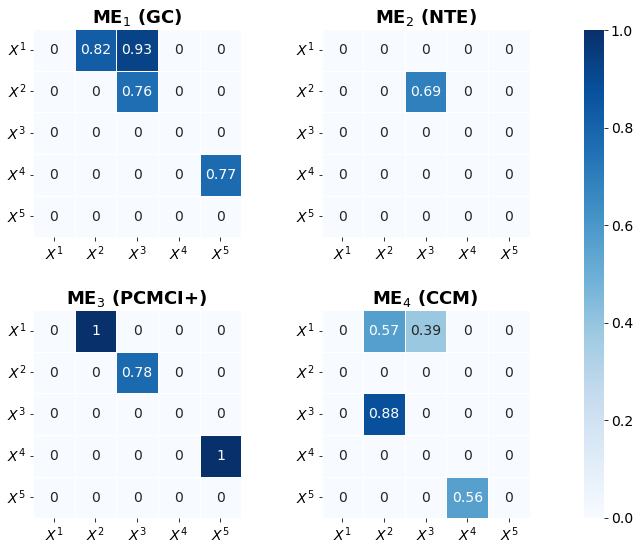

In [23]:
f, axes = plt.subplots(2, 2, figsize=(9,9))

f_1 = sns.heatmap(m_04, 
                  ax=axes[0][0], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names,
                  annot_kws={'size':14},
                  square=True,
                  annot=True)
f_1.set_xticklabels(f_1.get_xticklabels(), fontsize=14)
f_1.set_yticklabels(f_1.get_yticklabels(), rotation=0, fontsize=14)
f_1.set_title('$\mathbf{ME}_1$ (GC)', fontsize=18, fontweight='bold')

f_2 = sns.heatmap(m_02, 
                  ax=axes[0][1], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  annot_kws={'size':14},
                  square=True,
                  annot=True)
f_2.set_xticklabels(f_2.get_xticklabels(), fontsize=14)
f_2.set_yticklabels(f_2.get_yticklabels(), rotation=0, fontsize=14)
f_2.set_title('$\mathbf{ME}_2$ (NTE)', fontsize=18, fontweight='bold')

f_3 = sns.heatmap(m_03, 
                  ax=axes[1][0], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  annot_kws={'size':14},
                  square=True,
                  annot=True)
f_3.set_xticklabels(f_3.get_xticklabels(), fontsize=14)
f_3.set_yticklabels(f_3.get_yticklabels(), rotation=0, fontsize=14)
f_3.set_title('$\mathbf{ME}_3$ (PCMCI+)', fontsize=18, fontweight='bold')

cbar_ax = f.add_axes([.98, .126, .03, 0.752])
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)

f_4 = sns.heatmap(m_01, 
                  ax=axes[1][1], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar_ax=cbar_ax, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  annot_kws={'size':14},
                  square=True,
                  annot=True)
f_4.set_xticklabels(f_4.get_xticklabels(), fontsize=14)
f_4.set_yticklabels(f_4.get_yticklabels(), rotation=0, fontsize=14)
f_4.set_title('$\mathbf{ME}_4$ (CCM)', fontsize=18, fontweight='bold')

plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.savefig('C:/Users/zhipe/OneDrive/Desktop/Master thesis/codes/examples/results/Figure_4_6.jpg', 
            bbox_inches = 'tight',
            pad_inches=0.2,
            dpi=300)


In [24]:
def l2_ensemble_1(X_1, X_2, X_3, X_4, 
                acc_1, acc_2, acc_3, acc_4, 
                threshold=1.9, boundry=0.3):
    
    # The first filter for l1_ensmeble results.
    X_1[acc_1<0.9]=0.
    X_2[acc_2<0.9]=0.
    X_3[acc_3<0.9]=0.
    X_4[acc_4<0.9]=0.
    n, m = X_1.shape
    strength_ensemble = np.zeros((n,m))
    
    # ensemble procedure
    for u in range(n):
        for v in range(m):
            
            # reshape the data for further process
            ensemble_temp = np.hstack((X_1[u,v], X_2[u,v], X_3[u,v], X_4[u,v]))
            weight = np.hstack((acc_1[u,v], acc_2[u,v], acc_3[u,v], acc_4[u,v]))

            # normalizded the weight
            weight_temp = weight.copy()
            weight_temp[ensemble_temp<=0.3] = 0.
            normalized_weight = weight_temp / weight_temp.sum()
            
            # the causal strength if the causality relationship is true
            target = (ensemble_temp * normalized_weight).sum()
            
            # the precedure to determine the ensemble causality relationship
            if np.count_nonzero(ensemble_temp) > 2:   
                strength_ensemble[u,v] = target
            if np.count_nonzero(ensemble_temp) < 2:
                strength_ensemble[u,v] = 0.
            if np.count_nonzero(ensemble_temp) == 2:
                temp  = weight.copy()
                temp.sort()
                if temp[-1] > 9.9:
                    strength_ensemble[u,v] = target
                elif temp[-2] > threshold:
                    strength_ensemble[u,v] = target
                else:
                    strength_ensemble[u,v] = 0.
    
    # filter the final results
    strength_ensemble = direction_choosing(strength_ensemble)
    strength_ensemble = np.around(strength_ensemble,4)
    strength_ensemble[strength_ensemble<boundry] = 0.

    return strength_ensemble

In [25]:
rule_ensemble = l2_ensemble_1(m_01, m_02, m_03, m_04, 
                            acc_1, acc_2, acc_3, acc_4,
                            threshold=1.1, boundry=0.3)
rule_ensemble

array([[0.    , 0.9997, 0.5168, 0.    , 0.    ],
       [0.    , 0.    , 0.7494, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.9995],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

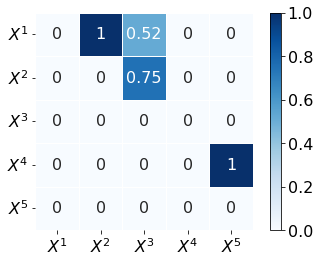

In [26]:
fig_00 = sns.heatmap(rule_ensemble, 
                    vmin=0, 
                    vmax=1, 
                    cmap='Blues',  
                    linewidths=.5, 
                    xticklabels=feature_names, 
                    yticklabels=feature_names, 
                    cbar=False,
                    annot_kws={'size':16},
                    square=True,
                    annot=True)
fig_00.set_xticklabels(fig_00.get_xticklabels(), fontsize=16)
fig_00.set_yticklabels(fig_00.get_yticklabels(), rotation=0, fontsize=16)

#cax = plt.gcf().axes[-1]
#cax.tick_params(labelsize=16)
cbar_ax = f.add_axes([.98, .126, .03, 0.752])

cb = fig_00.figure.colorbar(fig_00.collections[0]) 
cb.ax.tick_params(labelsize=16)
cb.ax = cbar_ax

plt.savefig('C:/Users/zhipe/OneDrive/Desktop/Master thesis/codes/examples/results/Figure_4_7_b.jpg', 
            bbox_inches = 'tight',
            pad_inches=0.2,
            dpi=300)

In [27]:
score = ce.evaluation()
print('Normalized_score:')
print(score)

Normalized_score:
0.8


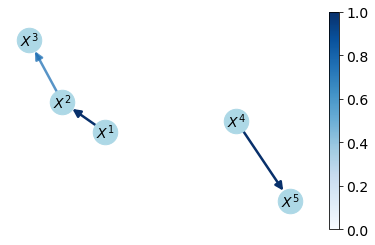

In [28]:
Graphic = causality_plotting(strength=strength_ensemble, 
                             feature_names=feature_names, 
                             #title='Example_1: Linear FakeData', 
                             name_size='short',
                             node_color="lightblue",
                             node_size = 600,
                             title_size=16,
                             seed=0)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)

plt.savefig('C:/Users/zhipe/OneDrive/Desktop/Master thesis/codes/examples/results/Figure_4_7.jpg', 
            bbox_inches = 'tight',
            pad_inches=0.2,
            dpi=300)

In [29]:
result = np.array([
    [0.,1.,0.,0.,0.],
    [0.,0.,1.,0.,0.],
    [0.,0.,0.,0.,0.],
    [0.,0.,0.,0.,1.],
    [0.,0.,0.,0.,0.],
 ])

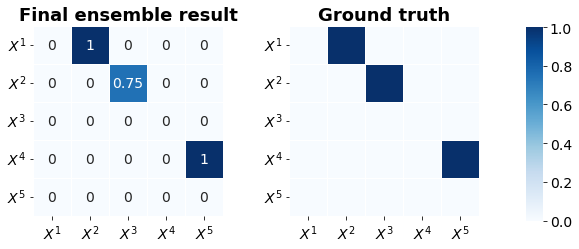

In [30]:
f_1, axes_1 = plt.subplots(1, 2, figsize=(8,8))
cbar_ax_1 = f_1.add_axes([.98, .33, .03, 0.336])

fig_0 = sns.heatmap(strength_ensemble, 
                    ax=axes_1[0], 
                    vmin=0, 
                    vmax=1, 
                    cmap='Blues', 
                    cbar=False, 
                    linewidths=.5, 
                    xticklabels=feature_names, 
                    yticklabels=feature_names, 
                    annot_kws={'size':14},
                    square=True,
                    annot=True)
fig_0.set_xticklabels(fig_0.get_xticklabels(), fontsize=14)
fig_0.set_yticklabels(fig_0.get_yticklabels(), rotation=0, fontsize=14)
fig_0.set_title('Final ensemble result', fontsize=18, fontweight='bold')

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)

fig_1 = sns.heatmap(result, 
                    ax=axes_1[1], 
                    vmin=0, 
                    vmax=1, 
                    cmap='Blues', 
                    cbar_ax=cbar_ax_1, 
                    linewidths=.5, 
                    xticklabels=feature_names, 
                    yticklabels=feature_names, 
                    square=True)
fig_1.set_xticklabels(fig_1.get_xticklabels(), fontsize=14)
fig_1.set_yticklabels(fig_1.get_yticklabels(), rotation=0, fontsize=14)
fig_1.set_title('Ground truth', fontsize=18, fontweight='bold')


plt.subplots_adjust(wspace=0.35)

plt.savefig('C:/Users/zhipe/OneDrive/Desktop/Master thesis/codes/examples/results/Figure_4_8.jpg', 
            bbox_inches = 'tight',
            pad_inches=0.2,
            dpi=300)

